# **FER Model Training**


### **Table of Contents**
---

* [Importing Libraries](#1)
* [Helper Functions](#2)
* [Loading and Inspecting the Data](#3)
* [Data Exploration](#4)
* [Preparing the data for training](#5)
* [Initial Models for Training](#6)
  >* [CNN Model 1 - Baseline Model](#7)
  >* [CNN Model 2 - Overfitting and Regularised Model](#8)
  >* [CNN Model 2 with Leaky ReLu Activation](#9)
  >* [CNN Model 2 with Data Augmentation](#10)
* [Initial Model Results](#11)
* [Hyperparameter Optimisation with Grid Search](#12)
  >* [Optimising the Pooling Layers and Activation Function](#13)
  >* [Optimising the Kernel Size and Dropout Regularisation](#14)
  >* [Optimising the Padding](#15)
  >* [Optimising the Optimiser and Learning Rate](#16)
* [Combining the Optimised Models](#17)
  >* [Combining the Pooling Layers and Activation Function](#18)
  >>* [Combined Model 1 Results](#19)
  >>* [Model 2 vs Combined Model 1](#20)
  >* [Combining the Kernel Size and Dropout Regularisation](#21)
  >>* [Combined Model 2 Results](#22)
  >>* [Model 2 vs Combined Model 2](#23)
  >* [Combining the Optimiser and Learning Rate](#24)
  >>* [Combined Model 3 Results](#25)
  >>* [Model 2 vs Combined Model 3](#26)
  >* [Final Combined Model](#27)
  >>* [Final Combined Model Results](#28)
  >>* [Model 2 vs Final Combined Model](#29)
  >* [Final Combined Model with Data Augmentation](#30)
  >* [Final Combined Model with Data Augmentation Results](#31)
* [Final Model](#32)
  >* [Final Model with Data Augmentation](#33)
  >* [Final Model Results](#34)
* [Predictions for Model without Data Augmentation](#35)
* [Predictions for Model with Data Augmentation](#36)
* [Saving the Model](#37)
* [Conclusions](#38)
----

### **Importing Libraries** <a id="1"></a>

In [ ]:
! pip install scikeras

In [ ]:
import tensorflow as tf
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.utils import to_categorical, plot_model
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, classification_report
from prettytable import PrettyTable

### **Helper Functions** <a id="2"></a>

In [ ]:
# helper function for loading the dataframe, oversampling and reshaping images, and assigning the data onto training labels
def load_fer_dataset(df) :
  width, height = 48, 48
  x_train, x_test = df['pixels'], df['emotion']
  oversampler = RandomOverSampler(sampling_strategy='auto') # oversampling dataset to fix the imbalance problem

  x_train, x_test = oversampler.fit_resample(x_train.values.reshape(-1,1), x_test)
  x_train = pd.Series(x_train.flatten())
  x_train = np.array(list(map(str.split, x_train)), 'float32') / 255
  x_train = x_train.reshape(-1, width, height, 1)

  x_test = np.array(x_test)
  x_test = x_test.reshape(x_test.shape[0], 1)

  return train_test_split(x_train, x_test, test_size=0.2, random_state=45) # 20% test data

In [ ]:
def preprocess_labels(y_train, y_test, y_val, num_classes):
  return to_categorical(y_train, num_classes), to_categorical(y_test, num_classes), to_categorical(y_val, num_classes) # one hot encoding the training set, test set and validation set

In [ ]:
# plotting 7 samples from each emotion classes
def plot_all_emotions():
  fig = plt.figure(1, (12, 12))
  fig.suptitle("Images representing each emotion", fontsize=20, weight='bold')
  img_count = 0

  for num_emotion in sorted(df_explore.emotion.unique()):
      for emotion in range(len(df_explore.emotion.unique())):      
          pixel = df_explore[df_explore.emotion == num_emotion].pixels.iloc[img_count]
          pixel = np.array(pixel.split(' ')).reshape(48, 48).astype('float32')
          img_count += 1

          axis = plt.subplot(len(df_explore.emotion.unique()),
                             len(df_explore.emotion.unique()),
                             img_count)
          axis.imshow(pixel, cmap='gray')
          axis.axis('off')
          axis.set_title(decoded_emotions[num_emotion], fontsize=12)
  return plt.show()

In [ ]:
# plotting one sample belonging to a specific emotion class
def plot_one_emotion(emotion, location):
  pixel = df_explore[df_explore.emotion == emotion].pixels.iloc[location]
  pixel = np.array(pixel.split(' ')).reshape(48, 48).astype('float32')
  plt.title(decoded_emotions[emotion], fontsize=12, weight='bold')
  return plt.imshow(pixel, cmap='gray')

In [ ]:
# plotting all samples of images that have been augmented
def plot_augmentation_samples(train_datagen):
  fig = plt.figure(figsize=(25, 10))
  fig.suptitle("Data Augmentation Samples", fontsize=20, weight='bold')
  rows = 3
  columns = 10
  iterator = train_datagen.flow(x_train, batch_size=64)

  for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    plt.grid(False)
    batch = iterator.next()
    plt.imshow(np.squeeze(batch[0]), cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
  save_figure("Data Augmentation Samples", tight_layout=False)
  plt.show()

In [ ]:
# helper function for training the model i.e. running for epochs
def train_model(model, epoch, batch):  
  callbacks_list = [
                    EarlyStopping( # if the model doesn't improve its validation accuracy for up to 5 epochs, it will stop training
                        monitor='val_accuracy',
                        patience=3, # represents the number of epochs with no improvement to which the training will be terminated
                        verbose=1,
                        restore_best_weights=True
                        ),
                    ModelCheckpoint( # if the model reaches an optimal validation loss, it will be saved onto the directory so it can be loaded later
                        filepath='best-model.h5',
                        verbose=1,
                        monitor='val_loss',
                        save_best_only=True,
                        ),
                    ReduceLROnPlateau(
                        monitor='val_loss',
                        factor=np.sqrt(0.1),
                        patience=3,
                        verbose=1,
                        min_delta=0.0001
                        )
                    ]
                    
  return model.fit(x_train, 
                   y_train,
                   epochs = epoch,
                   batch_size = batch,
                   callbacks=callbacks_list,
                   validation_data = (x_val, y_val))

In [ ]:
# helper function for retrieving a data augmentation generator
def get_augmented_generator(train_datagen, batch):
  return train_datagen.flow(x_train, y_train, batch_size=batch)

In [ ]:
# helper function for training the model with the data augmentation generator
def train_augmented_model(model, train_datagen, epoch, batch):  
  callbacks_list = [
                    EarlyStopping( # if the model doesn't improve its validation accuracy for up to 5 epochs, it will stop training
                        monitor='val_accuracy',
                        patience=3, # represents the number of epochs with no improvement to which the training will be terminated
                        verbose=1,
                        restore_best_weights=True
                        ),
                    ModelCheckpoint( # if the model reaches an optimal validation loss, it will be saved onto the directory so it can be loaded later
                        filepath='best-model.h5',
                        verbose=1,
                        monitor='val_loss',
                        save_best_only=True,
                        ),
                    ReduceLROnPlateau(
                        monitor='val_loss',
                        factor=0.2,
                        patience=3,
                        verbose=1,
                        min_delta=0.0001
                        ),
                    ]

  return model.fit(get_augmented_generator(train_datagen, batch),
                   epochs = epoch,
                   steps_per_epoch = x_train.shape[0] // batch,
                   validation_data = (x_val, y_val),
                   callbacks=callbacks_list,
                   validation_steps = len(x_val) // batch)

In [ ]:
# retrieves all history keys of the model
def get_history_keys(history):
  return (history.history,
          history.history["loss"],
          history.history["val_loss"], 
          history.history["accuracy"],
          history.history["val_accuracy"])

# plots both the model loss and accuracy
def plot_model_history(history, name=""):
  history_dict, loss, val_loss, acc, val_acc = get_history_keys(history) # get histories
  epochs = range(1, len(loss) + 1)
  blue_dots = 'bo'
  solid_blue_line = 'b'

  # defining the history subplots 
  values, axis = plt.subplots(1, 2)
  values.suptitle(name, fontsize=14)
  values.set_size_inches(14, 6)

  # plotting the values on the axis for each subplot
  axis[0].plot(epochs, loss, blue_dots, label = 'Training loss')
  axis[0].plot(epochs, val_loss, solid_blue_line, label = 'Validation loss')
  axis[1].plot(epochs, acc, blue_dots, label = 'Training acc')
  axis[1].plot(epochs, val_acc, solid_blue_line, label = 'Validation acc')

  # defining the labels
  plt.setp(axis[0], xlabel='Epochs')
  plt.setp(axis[0], ylabel='Loss')
  plt.setp(axis[1], xlabel='Epochs')
  plt.setp(axis[1], ylabel='Accuracy')
  axis[0].set_title('Training and validation loss')
  axis[0].legend()
  axis[1].set_title('Training and validation acc')
  axis[1].legend()

  # printing out minimum/maximum validation loss and accuracy
  print(f"\nMin validation loss: {str(min(val_loss))} \nMax validation loss: {str(max(val_loss))} \nMin validation acc: {str(min(val_acc))} \nMax validation acc: {str(max(val_acc))}")

In [ ]:
# retrieves all history keys from the two models
def get_comparison_history_keys(history1, history2):
  return (history1.history,
          history2.history,
          history1.history["val_loss"], 
          history2.history["val_loss"], 
          history1.history["val_accuracy"],
          history2.history["val_accuracy"])


def compare_model_history(history1, history2, name="", key1="", key2=""):
  history_dict1, history_dict2, model_1_val_loss, model_2_val_loss, model_1_val_acc, model_2_val_acc = get_comparison_history_keys(history1, history2)
  epochs = range(1, len(model_1_val_loss) + 1)

  # defining the history subplots 
  values, axis = plt.subplots(1, 2)
  values.suptitle(name, fontsize=14)
  values.set_size_inches(14, 6)

  # plotting the values on the axis for each subplot
  axis[0].plot(epochs, model_1_val_loss, 'g', label = key1 + ' Loss')
  axis[0].plot(epochs, model_2_val_loss, 'b', label = key2 + ' Loss')
  axis[1].plot(epochs, model_1_val_acc, 'g', label = key1 + ' Accuracy')
  axis[1].plot(epochs, model_2_val_acc, 'b', label = key2 + ' Accuracy')

  # defining the labels
  plt.setp(axis[0], xlabel='Epochs')
  plt.setp(axis[0], ylabel='Loss')
  plt.setp(axis[1], xlabel='Epochs')
  plt.setp(axis[1], ylabel='Accuracy')
  axis[0].set_title('Validation Loss')
  axis[0].legend()
  axis[1].set_title('Validation Accuracy')
  axis[1].legend()

  # printing out minimum/maximum validation loss and accuracy for each model
  print(f"\n{key1} validation loss: {str(min(model_1_val_loss))} \n{key2} validation loss: {str(min(model_2_val_loss))}")
  print(f"\n{key1} validation accuracy: {str(max(model_1_val_acc))} \n{key2} validation accuracy: {str(max(model_2_val_acc))}")

In [ ]:
# helper function to plot the grid search results
def plot_grid_search_results(results):
    print(f"\nBest score = {'%.2f' % results.best_score_} using {results.best_params_}\n")
    mean_score = results.cv_results_['mean_test_score']
    standard_deviation = results.cv_results_['std_test_score']
    parameters = results.cv_results_['params']
    optimised_model = grid_searcher_result.best_estimator_
    accuracy = optimised_model.score(x_test, y_test)

    for mean, stdev, param in zip(mean_score, standard_deviation, parameters):
        print('mean test accuracy +/- std = {:.4f} +/- {:.4f} with: {}'.format(mean, stdev, param))
    print("\nAccuracy achieved on the best model")
    print("{:.2f}%".format(accuracy * 100))

In [ ]:
# helper function for saving the visualisations and images onto the directory
def save_figure(figure_name, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(".", figure_name + "." + fig_extension)
    print(figure_name, "has been saved")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### **Loading and Inspecting the Data** <a id="3"></a>

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Full-FER-2013-Dataset/fer2013.csv')
df.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [ ]:
df.tail()

emotion                                             pixels        Usage
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
df.describe()

emotion
count  35887.000000
mean       3.323265
std        1.873819
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        6.000000

In [ ]:
df['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

### **Data Exploration** <a id="4"></a>

In [ ]:
df_explore = df.copy()
df_explore.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [ ]:
decoded_emotions = {0:'Angry', 
                    1:'Disgusted', 
                    2:'Scared', 
                    3:'Happy', 
                    4: 'Sad', 
                    5: 'Suprised', 
                    6: 'Neutral'}

print("Distribution of samples per emotion:\n{}".format(df_explore.groupby("emotion").size()))

Distribution of samples per emotion:
emotion
0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
dtype: int64


In [ ]:
df_explore['emotion'].isna().sum()

0

In [ ]:
df_explore['pixels'].isna().sum()

0

In [ ]:
df_explore['Usage'].isna().sum()

0

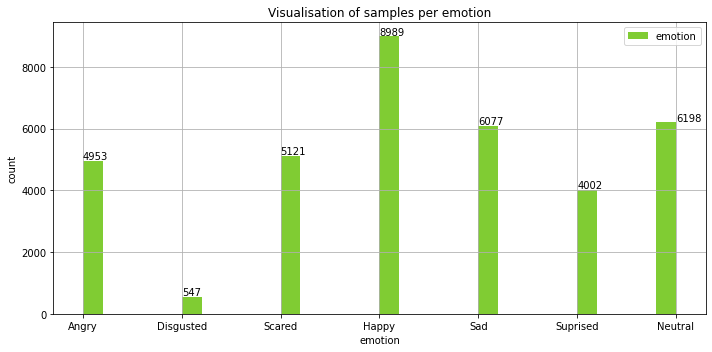

In [ ]:
df_explore.hist(bins=30, figsize=(10, 5), legend=True, color = (0.5,0.8,0.2,1))
plt.title('Visualisation of samples per emotion')
plt.xlabel('emotion')
plt.ylabel('count')
plt.xticks(np.array(list(decoded_emotions.keys())), decoded_emotions.values())

for i in range(len(df_explore["emotion"].value_counts())):
    plt.annotate(df_explore["emotion"].value_counts()[i], (i, df_explore["emotion"].value_counts()[i] + 50))

plt.tight_layout()
plt.show()

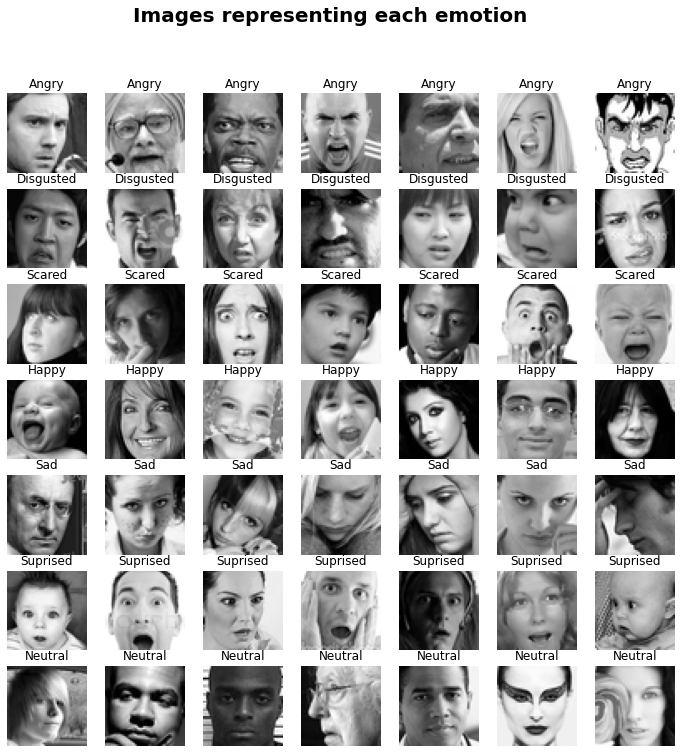

In [ ]:
plot_all_emotions()

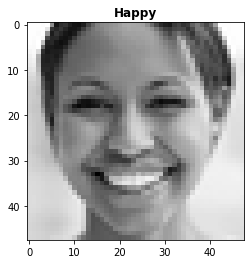

In [ ]:
# plot_one_emotion(emotion=1, location=1) # specific location
emotion = 3 # select an emotion key
plot_one_emotion(emotion=emotion, location=random.randint(1, 100)) # random location

### **Preparing the Data for Training** <a id="5"></a>

In [ ]:
# Training: 70
# Testing: 20
# Validation: 10
x_train, x_test, y_train, y_test = load_fer_dataset(df) # splitting the data into train/test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=45) # creating a validation set

num_classes = len(decoded_emotions)
y_train, y_test, y_val = preprocess_labels(y_train, y_test, y_val, num_classes=num_classes) # preprocessing labels

In [ ]:
len(df)

35887

In [ ]:
len(x_train) + len(x_test) + len(x_val) # after oversampling

62923

In [ ]:
len(x_train), len(x_test), len(x_val)

(45304, 12585, 5034)

### **Initial Models for Training** <a id="6"></a>

#### **CNN Model 1 - Baseline Model** <a id="7"></a>

In [ ]:
def model_1():
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(32, kernel_size=3, strides=1, padding="valid", activation='relu', input_shape=(x_train.shape[1:])))

  # 2nd convolutional layer
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding="same", activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # 3rd convolutional layer
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding="valid", activation='relu'))

  # 4th convolutional layer
  model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding="same", activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))

  # 5th convolutional layer
  model.add(layers.Conv2D(128, kernel_size=3, strides=1, padding="valid", activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())

  # Dense layers
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

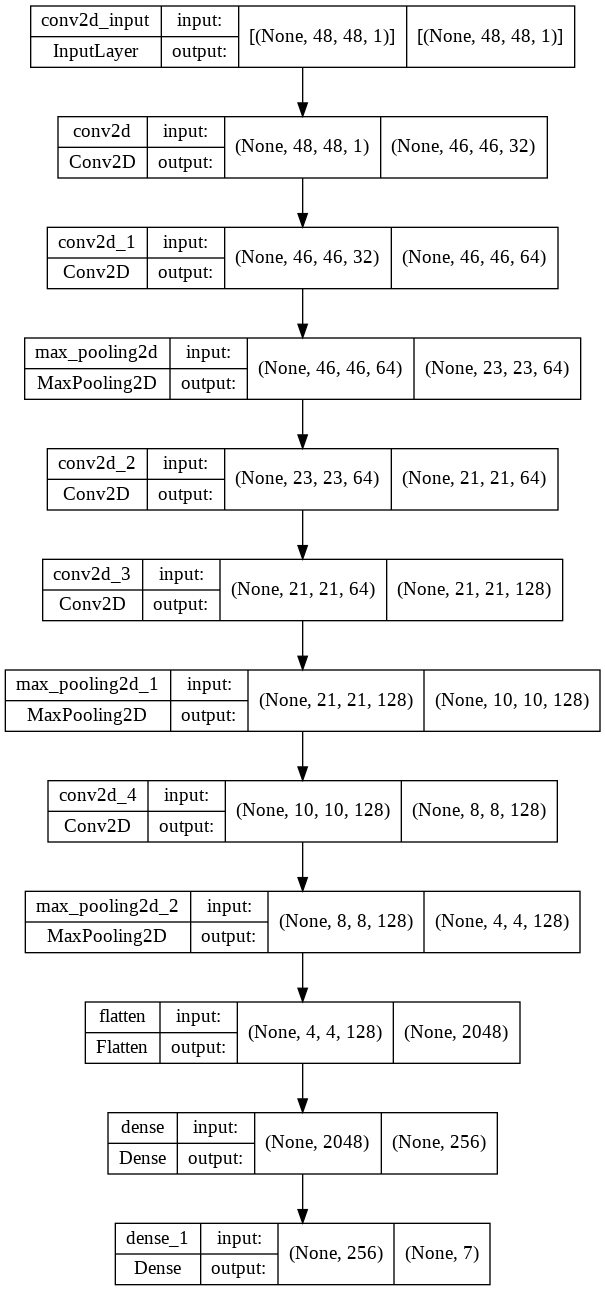

In [ ]:
model = model_1()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
history1 = train_model(model, 30, 64)
model.evaluate(x_test, y_test)

Epoch 1/30
708/708 [==============================] - ETA: 0s - loss: 1.7275 - accuracy: 0.3194
Epoch 1: val_loss improved from inf to 1.53934, saving model to best-model.h5
708/708 [==============================] - 14s 17ms/step - loss: 1.7275 - accuracy: 0.3194 - val_loss: 1.5393 - val_accuracy: 0.4182 - lr: 1.0000e-04
Epoch 2/30
705/708 [============================>.] - ETA: 0s - loss: 1.4399 - accuracy: 0.4635
Epoch 2: val_loss improved from 1.53934 to 1.35400, saving model to best-model.h5
708/708 [==============================] - 11s 16ms/step - loss: 1.4396 - accuracy: 0.4635 - val_loss: 1.3540 - val_accuracy: 0.4960 - lr: 1.0000e-04
Epoch 3/30
708/708 [==============================] - ETA: 0s - loss: 1.2667 - accuracy: 0.5315
Epoch 3: val_loss improved from 1.35400 to 1.23979, saving model to best-model.h5
708/708 [==============================] - 11s 16ms/step - loss: 1.2667 - accuracy: 0.5315 - val_loss: 1.2398 - val_accuracy: 0.5465 - lr: 1.0000e-04
Epoch 4/30
705/708 [

[1.1412922143936157, 0.8023837804794312]

#### **CNN Model 2 - Overfitting and Regularised Model** <a id="8"></a>

In [ ]:
def model_2():
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1:])))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 2nd convolutional layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 3rd convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 4th convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())

  # 1st fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))

  # 2nd fully connected dense layer
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))

  # final dense layer with number of classes
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

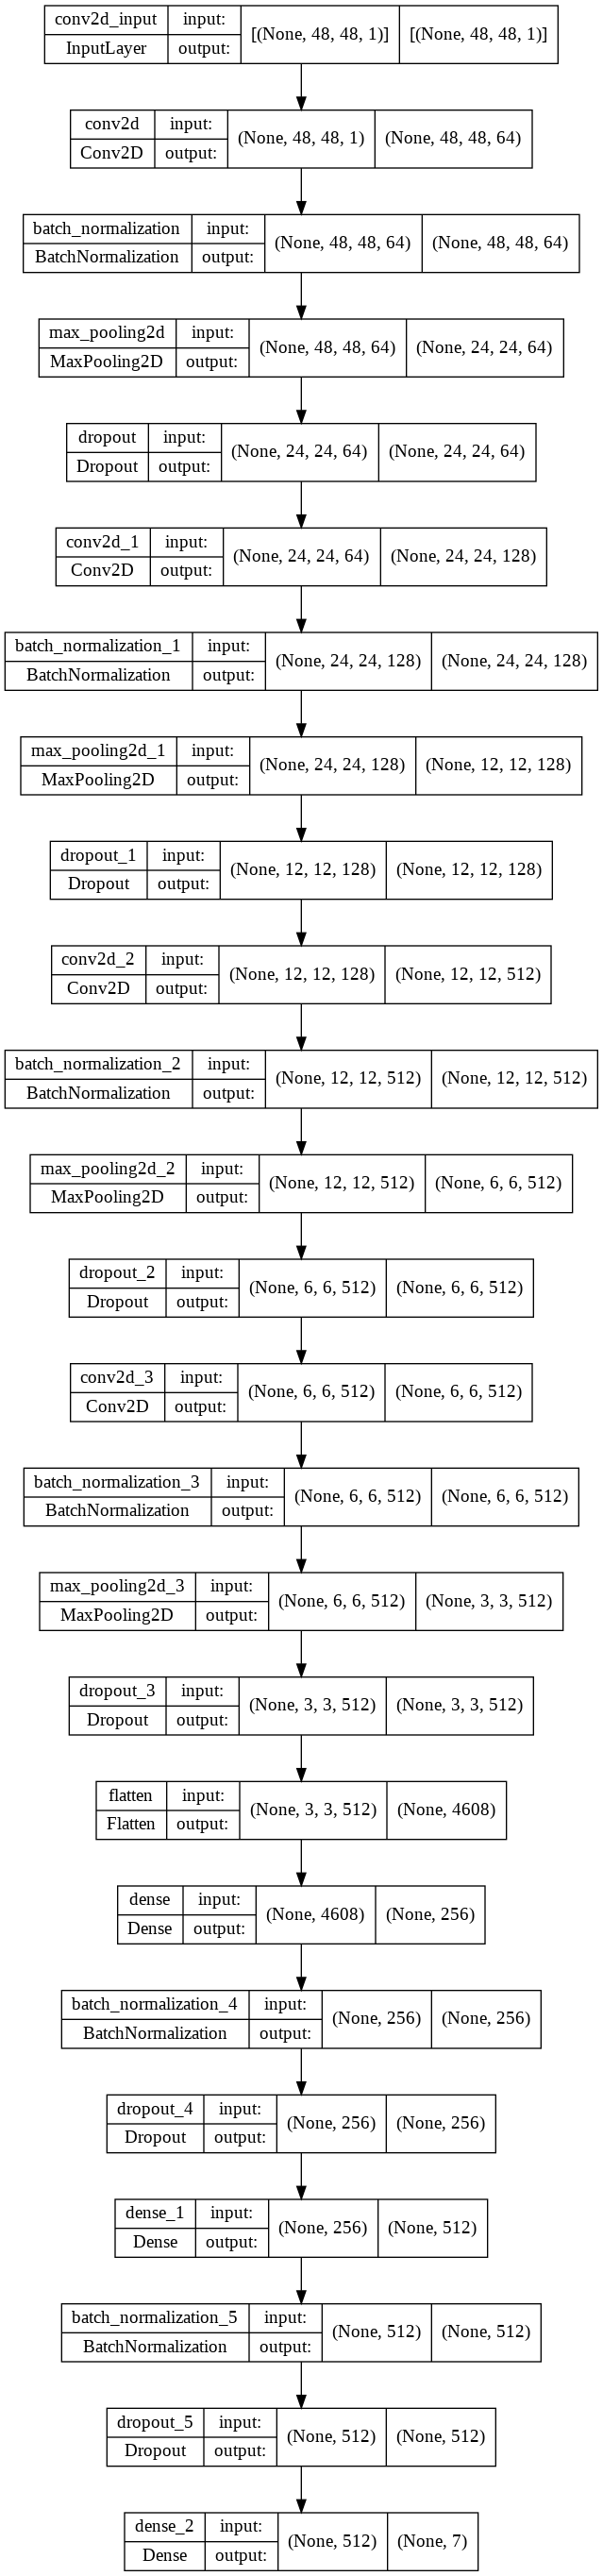

In [ ]:
model = model_2()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
history2 = train_model(model, 30, 64)
model.evaluate(x_test, y_test)

Epoch 1/30
708/708 [==============================] - ETA: 0s - loss: 2.2622 - accuracy: 0.2163
Epoch 1: val_loss improved from inf to 2.00889, saving model to best-model.h5
708/708 [==============================] - 31s 28ms/step - loss: 2.2622 - accuracy: 0.2163 - val_loss: 2.0089 - val_accuracy: 0.2437 - lr: 1.0000e-04
Epoch 2/30
707/708 [============================>.] - ETA: 0s - loss: 1.9367 - accuracy: 0.2967
Epoch 2: val_loss improved from 2.00889 to 1.71000, saving model to best-model.h5
708/708 [==============================] - 18s 26ms/step - loss: 1.9364 - accuracy: 0.2968 - val_loss: 1.7100 - val_accuracy: 0.3607 - lr: 1.0000e-04
Epoch 3/30
706/708 [============================>.] - ETA: 0s - loss: 1.7139 - accuracy: 0.3693
Epoch 3: val_loss improved from 1.71000 to 1.55323, saving model to best-model.h5
708/708 [==============================] - 18s 26ms/step - loss: 1.7135 - accuracy: 0.3695 - val_loss: 1.5532 - val_accuracy: 0.4261 - lr: 1.0000e-04
Epoch 4/30
706/708 [

[0.6234413385391235, 0.8416368961334229]

#### **CNN Model 2 with Leaky ReLu** <a id="9"></a>

In [ ]:
def model_3():
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU(), input_shape=(x_train.shape[1:])))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 2nd convolutional layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU()))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 3rd convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU()))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 4th convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation=tf.keras.layers.LeakyReLU()))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())

  # 1st fully connected dense layer
  model.add(layers.Dense(256, activation=tf.keras.layers.LeakyReLU()))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))

  # 2nd fully connected dense layer
  model.add(layers.Dense(512, activation=tf.keras.layers.LeakyReLU()))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))

  # final dense layer with number of classes
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

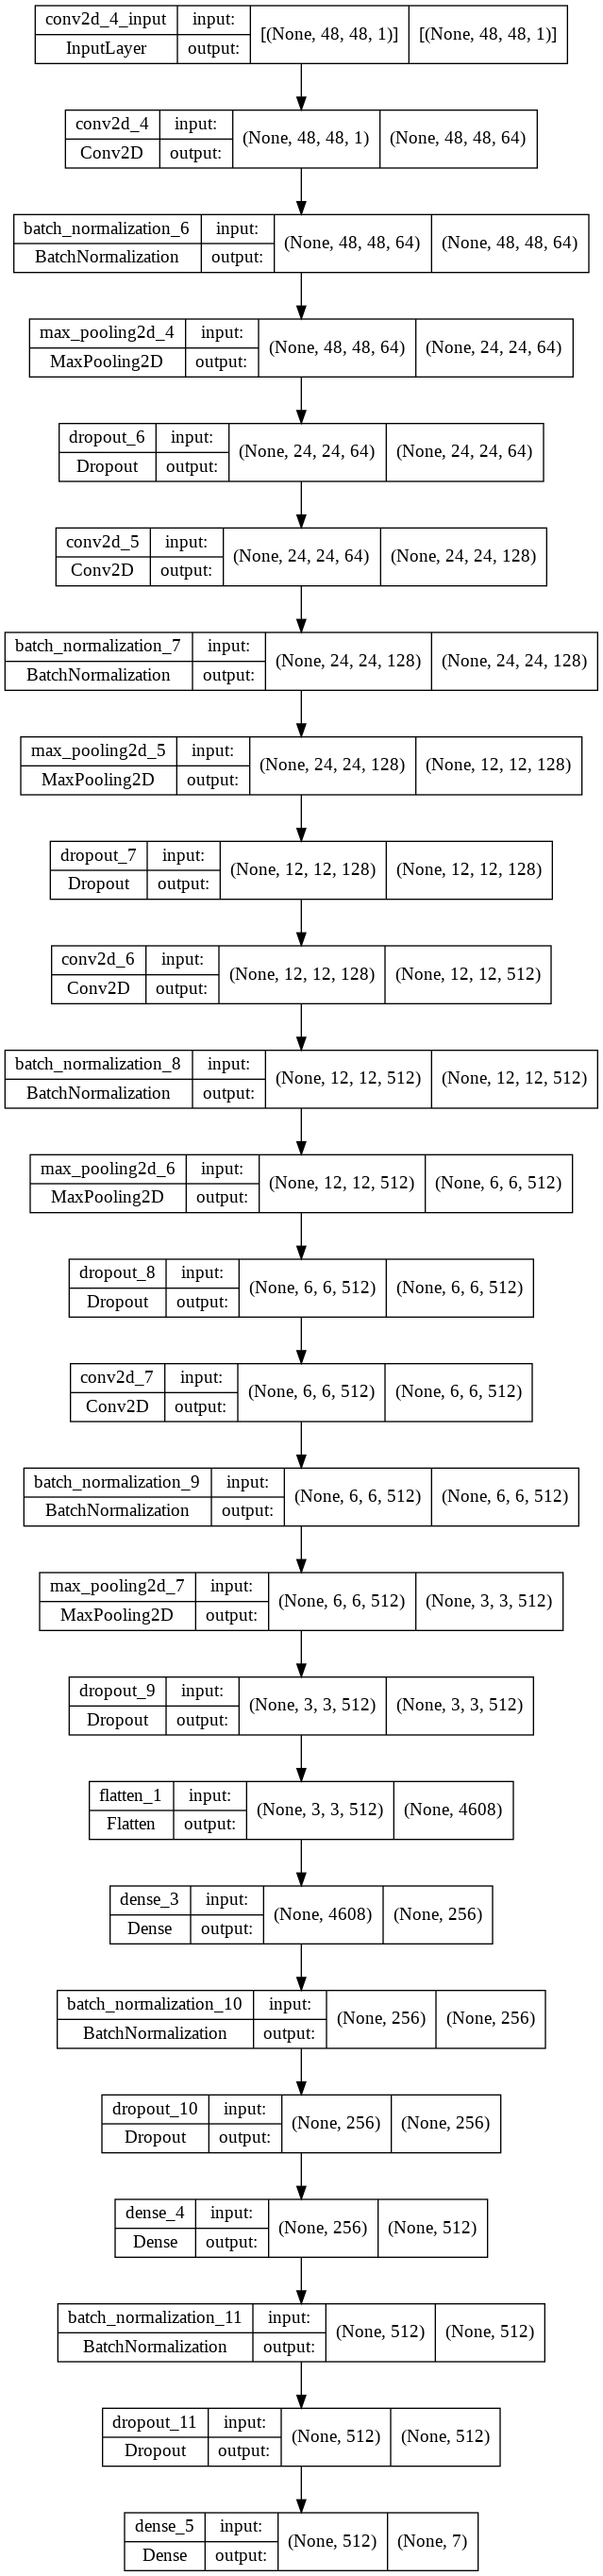

In [ ]:
model = model_3()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
history3 = train_model(model, 30, 64)
model.evaluate(x_test, y_test)

Epoch 1/30
708/708 [==============================] - ETA: 0s - loss: 2.1218 - accuracy: 0.2501
Epoch 1: val_loss improved from inf to 1.83007, saving model to best-model.h5
708/708 [==============================] - 31s 28ms/step - loss: 2.1218 - accuracy: 0.2501 - val_loss: 1.8301 - val_accuracy: 0.3192 - lr: 1.0000e-04
Epoch 2/30
707/708 [============================>.] - ETA: 0s - loss: 1.7720 - accuracy: 0.3515
Epoch 2: val_loss improved from 1.83007 to 1.65118, saving model to best-model.h5
708/708 [==============================] - 20s 29ms/step - loss: 1.7718 - accuracy: 0.3514 - val_loss: 1.6512 - val_accuracy: 0.3977 - lr: 1.0000e-04
Epoch 3/30
707/708 [============================>.] - ETA: 0s - loss: 1.5677 - accuracy: 0.4252
Epoch 3: val_loss improved from 1.65118 to 1.31767, saving model to best-model.h5
708/708 [==============================] - 19s 27ms/step - loss: 1.5678 - accuracy: 0.4252 - val_loss: 1.3177 - val_accuracy: 0.5079 - lr: 1.0000e-04
Epoch 4/30
708/708 [

[0.6354373097419739, 0.8318633437156677]

#### **CNN Model 2 with Data Augmentation** <a id="10"></a>

Data Augmentation Samples has been saved


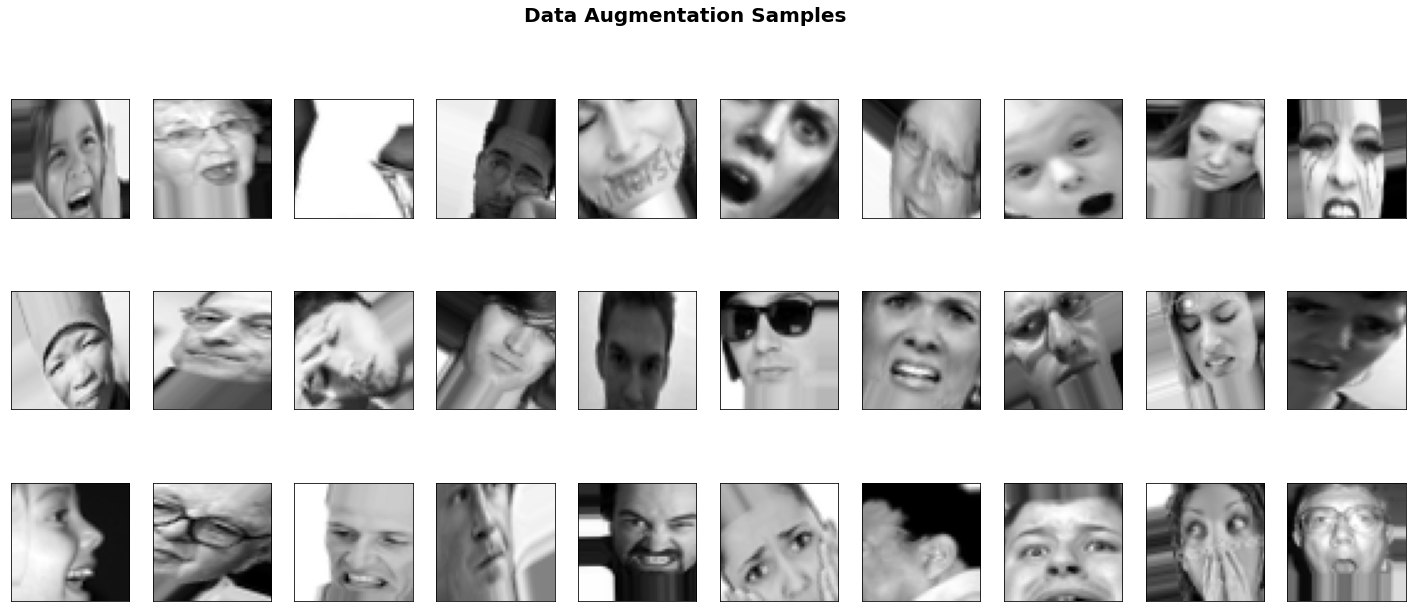

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.4,
    zoom_range=0.4,
    fill_mode='nearest'
)

plot_augmentation_samples(train_datagen)

In [ ]:
model = model_2()

history4 = train_augmented_model(model, train_datagen, 80, 128)
model.evaluate(x_test, y_test)

Epoch 1/80
352/353 [============================>.] - ETA: 0s - loss: 2.4151 - accuracy: 0.1679
Epoch 1: val_loss improved from inf to 2.17855, saving model to best-model.h5
353/353 [==============================] - 18s 48ms/step - loss: 2.4149 - accuracy: 0.1679 - val_loss: 2.1786 - val_accuracy: 0.1263 - lr: 1.0000e-04
Epoch 2/80
352/353 [============================>.] - ETA: 0s - loss: 2.1947 - accuracy: 0.1784
Epoch 2: val_loss improved from 2.17855 to 2.04914, saving model to best-model.h5
353/353 [==============================] - 17s 48ms/step - loss: 2.1945 - accuracy: 0.1785 - val_loss: 2.0491 - val_accuracy: 0.1780 - lr: 1.0000e-04
Epoch 3/80
352/353 [============================>.] - ETA: 0s - loss: 2.1224 - accuracy: 0.1852
Epoch 3: val_loss improved from 2.04914 to 1.90840, saving model to best-model.h5
353/353 [==============================] - 17s 48ms/step - loss: 2.1224 - accuracy: 0.1853 - val_loss: 1.9084 - val_accuracy: 0.2304 - lr: 1.0000e-04
Epoch 4/80
352/353 [

[1.134113073348999, 0.5738577842712402]

### **Initial Results** <a id="11"></a>


Min validation loss: 0.9167398810386658 
Max validation loss: 1.5393399000167847 
Min validation acc: 0.41815653443336487 
Max validation acc: 0.7904251217842102


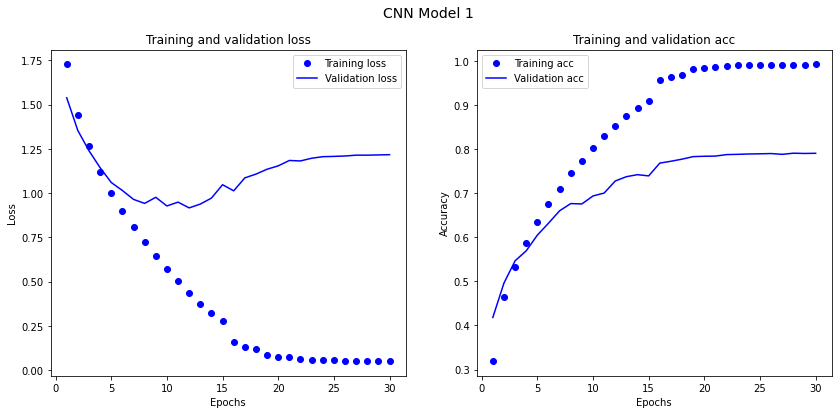

In [ ]:
plot_model_history(history1, name="CNN Model 1")


Min validation loss: 0.5889896154403687 
Max validation loss: 2.0088906288146973 
Min validation acc: 0.24374255537986755 
Max validation acc: 0.8458482027053833


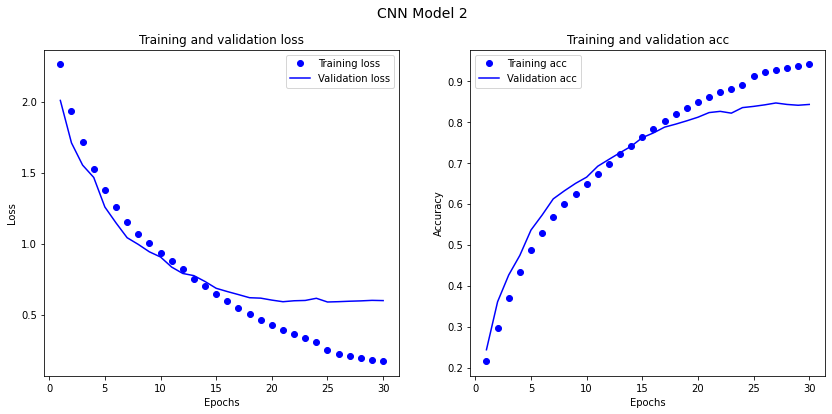

In [ ]:
plot_model_history(history2, name="CNN Model 2")


Min validation loss: 0.6021990776062012 
Max validation loss: 2.0196313858032227 
Min validation acc: 0.2445371448993683 
Max validation acc: 0.8373063206672668


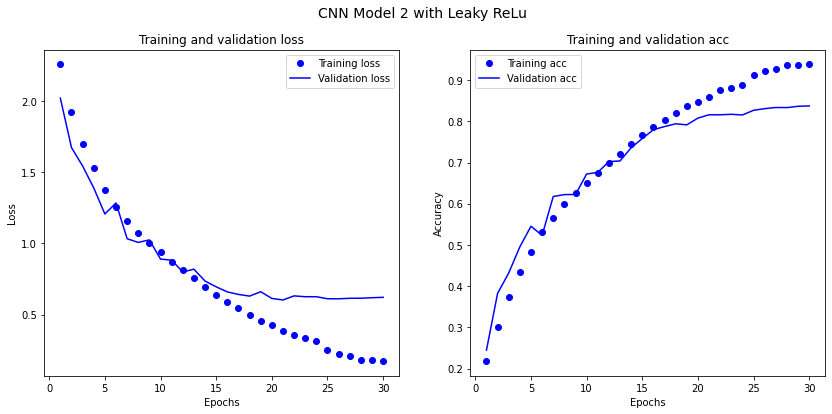

In [ ]:
plot_model_history(history3, name="CNN Model 2 with Leaky ReLu")


Min validation loss: 1.1337430477142334 
Max validation loss: 2.1785547733306885 
Min validation acc: 0.12634088099002838 
Max validation acc: 0.5746920704841614


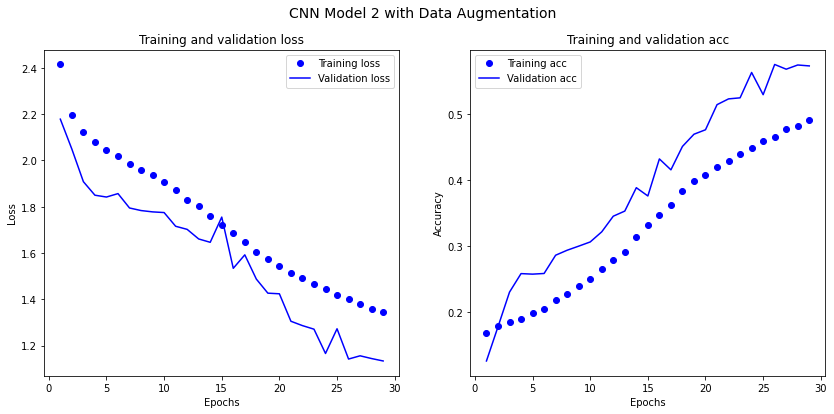

In [ ]:
plot_model_history(history4, name="CNN Model 2 with Data Augmentation")

After analysing all the results, Model 2 has proven to be most promising. Therefore, it will be shortlisted for fine-tuning.

### **Hyperparameter Optimisation** <a id="12"></a>

#### **Tuning the activation functions and pooling types** <a id="13"></a>

In [ ]:
def create_model(pool_type='max', conv_activation='relu', dropout_rate=0.25):
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation=conv_activation, input_shape=(x_train.shape[1:])))
  model.add(layers.BatchNormalization())
  if pool_type == 'max':
    model.add(layers.MaxPooling2D((2, 2)))
  if pool_type == 'average':
    model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))    

  # 2nd convolutional layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation=conv_activation))
  model.add(layers.BatchNormalization())
  if pool_type == 'max':
    model.add(layers.MaxPooling2D((2, 2)))
  if pool_type == 'average':
    model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 3rd convolutional layer
  model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation=conv_activation))
  model.add(layers.BatchNormalization())
  if pool_type == 'max':
    model.add(layers.MaxPooling2D((2, 2)))
  if pool_type == 'average':
    model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 4th convolutional layer
  model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation=conv_activation))
  model.add(layers.BatchNormalization())
  if pool_type == 'max':  
    model.add(layers.MaxPooling2D((2, 2)))
  if pool_type == 'average':
    model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  model.add(layers.Flatten())

  # 1st fully connected dense layer
  model.add(layers.Dense(256, activation=conv_activation))
  model.add(layers.BatchNormalization())
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 2nd fully connected dense layer
  model.add(layers.Dense(256, activation=conv_activation))
  model.add(layers.BatchNormalization())
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # final dense layer with number of classes
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# wrapping the existing model around KerasClassifier to use it with scikit-learn
model = KerasClassifier(build_fn=create_model, pool_type='max', conv_activation='relu', dropout_rate=0.25, verbose=1)

# specifying the hyperparameters to be tuned during the grid search 
param_grid = {
    'pool_type': ['max', 'average'],
    'conv_activation': ['relu', tf.keras.layers.LeakyReLU(), 'tanh'],    
    'epochs': [30],
}

# fitting the model and evaluating the results
grid_searcher = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_searcher_result = grid_searcher.fit(x_train, y_train)
plot_grid_search_results(grid_searcher_result)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
1416/1416 [==============================] - 18s 11ms/step - loss: 2.2184 - accuracy: 0.2192
Epoch 2/30
1416/1416 [==============================] - 15s 10ms/step - loss: 1.8781 - accuracy: 0.3062
Epoch 3/30
1416/1416 [==============================] - 15s 10ms/step - loss: 1.6445 - accuracy: 0.3893
Epoch 4/30
1416/1416 [==============================] - 15s 10ms/step - loss: 1.4567 - accuracy: 0.4571
Epoch 5/30
1416/1416 [==============================] - 15s 10ms/step - loss: 1.3201 - accuracy: 0.5069
Epoch 6/30
1416/1416 [==============================] - 15s 10ms/step - loss: 1.2144 - accuracy: 0.5461
Epoch 7/30
1416/1416 [==============================] - 15s 10ms/step - loss: 1.1278 - accuracy: 0.5776
Epoch 8/30
1416/1416 [==============================] - 15s 10ms/step - loss: 1.0592 - accuracy: 0.6029
Epoch 9/30
1416/1416 [==============================] - 15s 10ms/step - loss: 1.0053 - accuracy: 0.6250
Epoch 10/30
1416/1416 [==============================] - 15s 10m

#### **Tuning the kernel size and dropout regularisation** <a id="14"></a>

In [ ]:
def create_model(kernel_size=3, dropout_rate=0.25):
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(64, kernel_size=kernel_size, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1:])))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))    

  # 2nd convolutional layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 3rd convolutional layer
  model.add(layers.Conv2D(256, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 4th convolutional layer
  model.add(layers.Conv2D(256, kernel_size=kernel_size, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  model.add(layers.Flatten())

  # 1st fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 2nd fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # final dense layer with number of classes
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# wrapping the existing model around KerasClassifier to use it with scikit-learn
model = KerasClassifier(build_fn=create_model, kernel_size=3, dropout_rate=0.25, verbose=1)

# specifying the hyperparameters to be tuned during the grid search 
param_grid = {
    'kernel_size': [3, 5, 7],
    'dropout_rate': [0.2, 0.25, 0.3, 0.35],
    'epochs': [30],
    'batch_size': [64, 128],
}

# fitting the model and evaluating the results
grid_searcher = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_searcher_result = grid_searcher.fit(x_train, y_train)
plot_grid_search_results(grid_searcher_result)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
354/354 [==============================] - 11s 25ms/step - loss: 2.1357 - accuracy: 0.2430
Epoch 2/30
354/354 [==============================] - 8s 24ms/step - loss: 1.7797 - accuracy: 0.3546
Epoch 3/30
354/354 [==============================] - 8s 24ms/step - loss: 1.5331 - accuracy: 0.4419
Epoch 4/30
354/354 [==============================] - 8s 24ms/step - loss: 1.3613 - accuracy: 0.4999
Epoch 5/30
354/354 [==============================] - 8s 24ms/step - loss: 1.2353 - accuracy: 0.5421
Epoch 6/30
354/354 [==============================] - 8s 24ms/step - loss: 1.1381 - accuracy: 0.5813
Epoch 7/30
354/354 [==============================] - 8s 24ms/step - loss: 1.0502 - accuracy: 0.6088
Epoch 8/30
354/354 [==============================] - 8s 24ms/step - loss: 0.9773 - accuracy: 0.6392
Epoch 9/30
354/354 [==============================] - 8s 24ms/step - loss: 0.9136 - accuracy: 0.6638
Epoch 10/30
354/354 [==============================] - 8s 24ms/step - loss: 0.8483 - accur

#### **Tuning the padding** <a id="15"></a>

In [ ]:
def create_model(padding='same', dropout_rate=0.2):
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(64, kernel_size=5, strides=1, padding=padding, activation='relu', input_shape=(48, 48, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))    

  # 2nd convolutional layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding=padding, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 3rd convolutional layer
  model.add(layers.Conv2D(256, kernel_size=5, strides=1, padding=padding, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 4th convolutional layer
  model.add(layers.Conv2D(256, kernel_size=5, strides=1, padding=padding, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  model.add(layers.Flatten())

  # 1st fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 2nd fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # final dense layer with number of classes
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# wrapping the existing model around KerasClassifier to use it with scikit-learn
model = KerasClassifier(build_fn=create_model, padding='same', dropout_rate=0.2, verbose=1)

# specifying the hyperparameters to be tuned during the grid search 
param_grid = {
    'padding': ['same', 'valid', 'causal'],
    'epochs': [30],
    'batch_size': [128],
}

# fitting the model and evaluating the results
grid_searcher = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_searcher_result = grid_searcher.fit(x_train, y_train)
plot_grid_search_results(grid_searcher_result)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py", line 1453, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py", line 726, in fit
    X=X, y=y, sample_weight=sample_weight, warm_start=self.warm_start, **kwargs,


Epoch 1/30
354/354 [==============================] - 10s 24ms/step - loss: 2.1119 - accuracy: 0.2486
Epoch 2/30
354/354 [==============================] - 8s 24ms/step - loss: 1.7603 - accuracy: 0.3606
Epoch 3/30
354/354 [==============================] - 8s 24ms/step - loss: 1.5295 - accuracy: 0.4397
Epoch 4/30
354/354 [==============================] - 8s 24ms/step - loss: 1.3559 - accuracy: 0.4989
Epoch 5/30
354/354 [==============================] - 9s 24ms/step - loss: 1.2279 - accuracy: 0.5445
Epoch 6/30
354/354 [==============================] - 8s 24ms/step - loss: 1.1251 - accuracy: 0.5804
Epoch 7/30
354/354 [==============================] - 8s 24ms/step - loss: 1.0421 - accuracy: 0.6133
Epoch 8/30
354/354 [==============================] - 8s 24ms/step - loss: 0.9696 - accuracy: 0.6388
Epoch 9/30
354/354 [==============================] - 9s 24ms/step - loss: 0.9070 - accuracy: 0.6643
Epoch 10/30
354/354 [==============================] - 8s 24ms/step - loss: 0.8489 - accur

#### **Tuning the optimiser and learning rate** <a id="16"></a>

In [ ]:
def create_model(optimizer=optimizers.Adam, learning_rate=0.0001, dropout_rate=0.2):
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1:])))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))    

  # 2nd convolutional layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 3rd convolutional layer
  model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 4th convolutional layer
  model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  model.add(layers.Flatten())

  # 1st fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # 2nd fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  if dropout_rate != 0:
    model.add(layers.Dropout(dropout_rate))  

  # final dense layer with number of classes
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizer(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
# wrapping the existing model around KerasClassifier to use it with scikit-learn
model = KerasClassifier(build_fn=create_model, optimizer=optimizers.Adam, learning_rate=0.0001, dropout_rate=0.2, verbose=1)

# specifying the hyperparameters to be tuned during the grid search 
param_grid = {
    'optimizer': [optimizers.RMSprop, optimizers.Adagrad, optimizers.Adam, optimizers.Adamax, optimizers.Nadam],
    'learning_rate': [0.0001, 0.00001, 0.0005, 0.00005],
    'epochs': [30],
    'batch_size': [64, 128],
}

# fitting the model and evaluating the results
grid_searcher = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_searcher_result = grid_searcher.fit(x_train, y_train)
plot_grid_search_results(grid_searcher_result)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/scikeras/wrappers.py:290: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  "``build_fn`` will be renamed to ``model`` in a future release,"


Epoch 1/30
708/708 [==============================] - 16s 18ms/step - loss: 2.0423 - accuracy: 0.2424
Epoch 2/30
708/708 [==============================] - 12s 18ms/step - loss: 1.5573 - accuracy: 0.4130
Epoch 3/30
708/708 [==============================] - 12s 18ms/step - loss: 1.2539 - accuracy: 0.5278
Epoch 4/30
708/708 [==============================] - 12s 18ms/step - loss: 1.0888 - accuracy: 0.5898
Epoch 5/30
708/708 [==============================] - 13s 18ms/step - loss: 0.9752 - accuracy: 0.6335
Epoch 6/30
708/708 [==============================] - 12s 18ms/step - loss: 0.9010 - accuracy: 0.6619
Epoch 7/30
708/708 [==============================] - 12s 18ms/step - loss: 0.8291 - accuracy: 0.6890
Epoch 8/30
708/708 [==============================] - 12s 18ms/step - loss: 0.7633 - accuracy: 0.7181
Epoch 9/30
708/708 [==============================] - 12s 18ms/step - loss: 0.7059 - accuracy: 0.7399
Epoch 10/30
708/708 [==============================] - 12s 18ms/step - loss: 0.646

### **Combining Models** <a id="17"></a>

#### **ReLu Activation with Average Pooling** <a id="18"></a>

In [ ]:
def combined_model_1():
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1:])))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 2nd convolutional layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 3rd convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 4th convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())

  # 1st fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))

  # 2nd fully connected dense layer
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))

  # final dense layer with number of classes
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

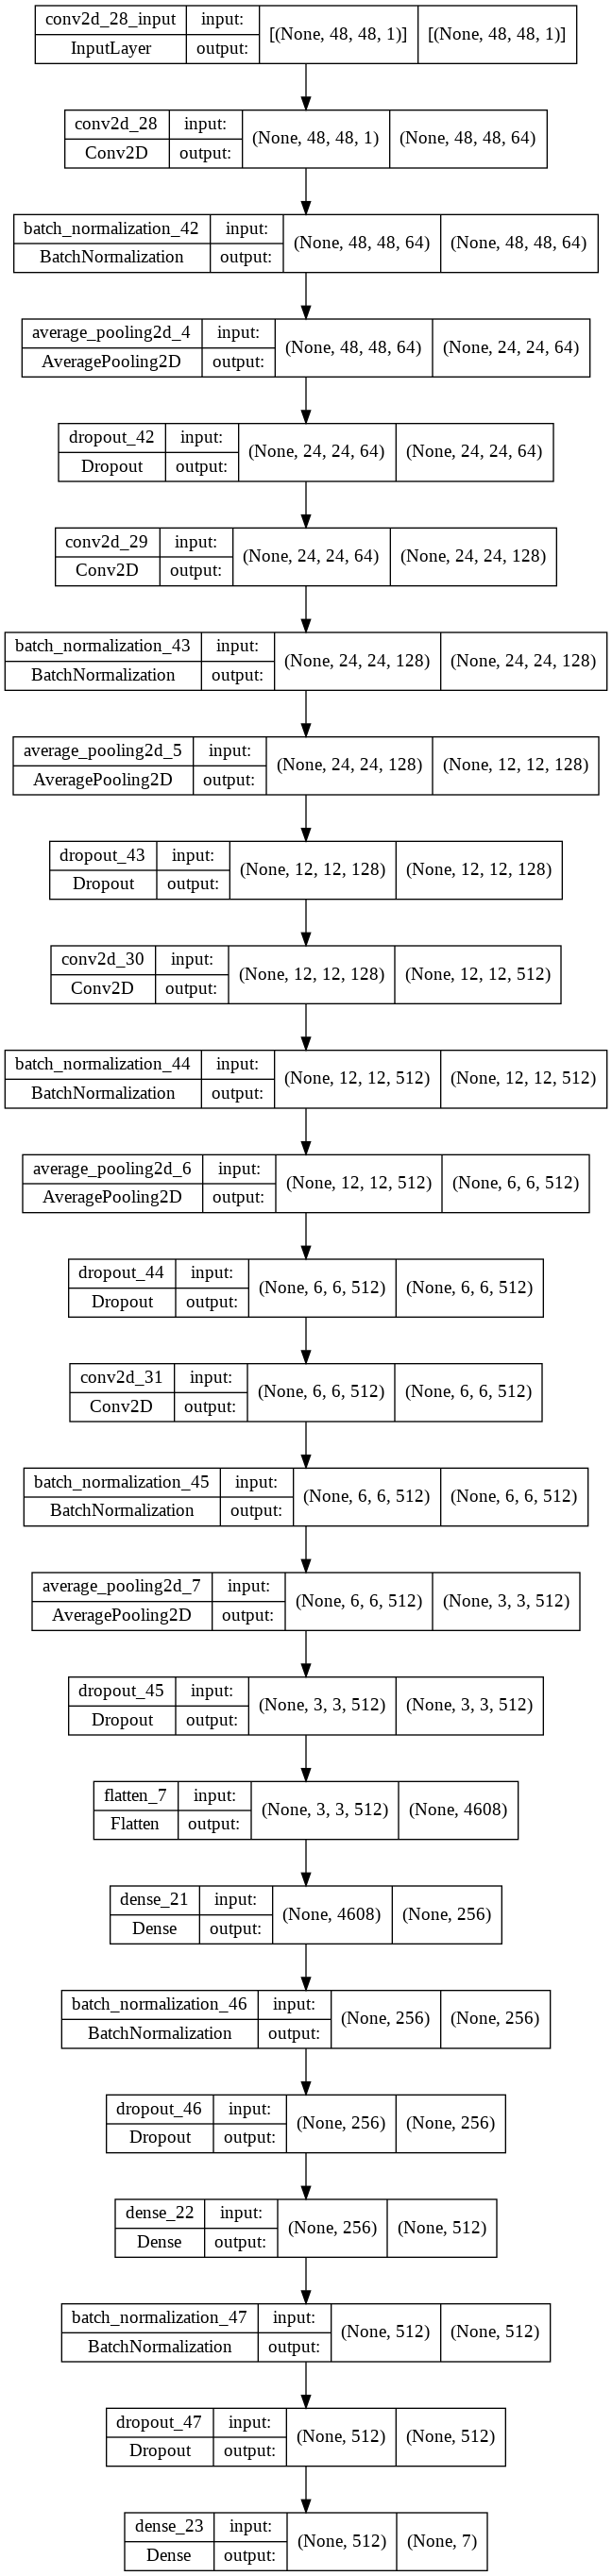

In [ ]:
model = combined_model_1()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
history5 = train_model(model, 30, 64)
model.evaluate(x_test, y_test)

Epoch 1/30
707/708 [============================>.] - ETA: 0s - loss: 2.1996 - accuracy: 0.2309
Epoch 1: val_loss improved from inf to 1.81243, saving model to best-model.h5
708/708 [==============================] - 19s 26ms/step - loss: 2.1993 - accuracy: 0.2310 - val_loss: 1.8124 - val_accuracy: 0.3270 - lr: 1.0000e-04
Epoch 2/30
708/708 [==============================] - ETA: 0s - loss: 1.8299 - accuracy: 0.3392
Epoch 2: val_loss improved from 1.81243 to 1.61387, saving model to best-model.h5
708/708 [==============================] - 18s 25ms/step - loss: 1.8299 - accuracy: 0.3392 - val_loss: 1.6139 - val_accuracy: 0.4120 - lr: 1.0000e-04
Epoch 3/30
708/708 [==============================] - ETA: 0s - loss: 1.5866 - accuracy: 0.4211
Epoch 3: val_loss improved from 1.61387 to 1.30976, saving model to best-model.h5
708/708 [==============================] - 18s 25ms/step - loss: 1.5866 - accuracy: 0.4211 - val_loss: 1.3098 - val_accuracy: 0.5028 - lr: 1.0000e-04
Epoch 4/30
707/708 [

[0.6088735461235046, 0.8438617587089539]

##### **Combine Model 1 Results** <a id="19"></a>


Min validation loss: 0.5592455863952637 
Max validation loss: 1.812427282333374 
Min validation acc: 0.32697656750679016 
Max validation acc: 0.844855010509491


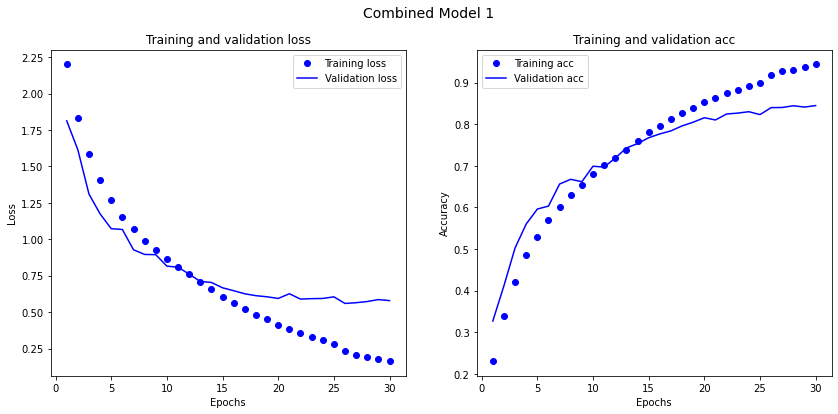

In [ ]:
plot_model_history(history5, name="Combined Model 1")

##### **Model 2 vs Combine Model 1** <a id="20"></a>


Model 2 validation loss: 0.5889896154403687 
Combined Model 1 validation loss: 0.5592455863952637

Model 2 validation accuracy: 0.8458482027053833 
Combined Model 1 validation accuracy: 0.844855010509491


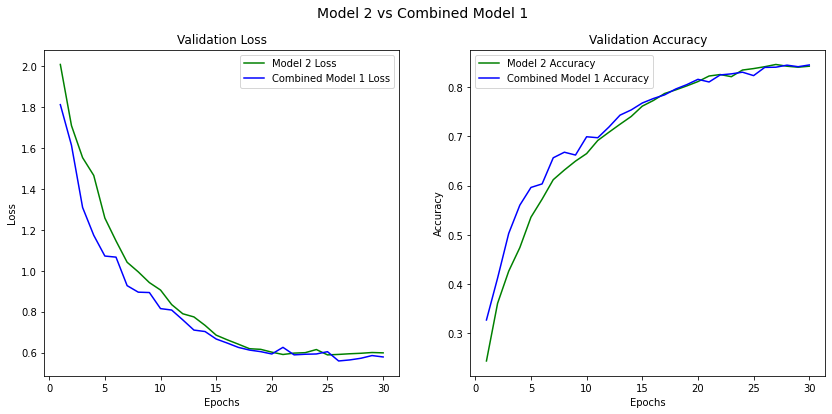

In [ ]:
compare_model_history(history2, history5, name="Model 2 vs Combined Model 1", key1="Model 2", key2="Combined Model 1")

#### **Kernel Size of 5 with Dropout Regularisation of 0.2** <a id="21"></a>

In [ ]:
def combined_model_2():
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1:])))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  # 2nd convolutional layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  # 3rd convolutional layer
  model.add(layers.Conv2D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))

  # 4th convolutional layer
  model.add(layers.Conv2D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Flatten())

  # 1st fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))

  # 2nd fully connected dense layer
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.2))

  # final dense layer with number of classes
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizers.Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

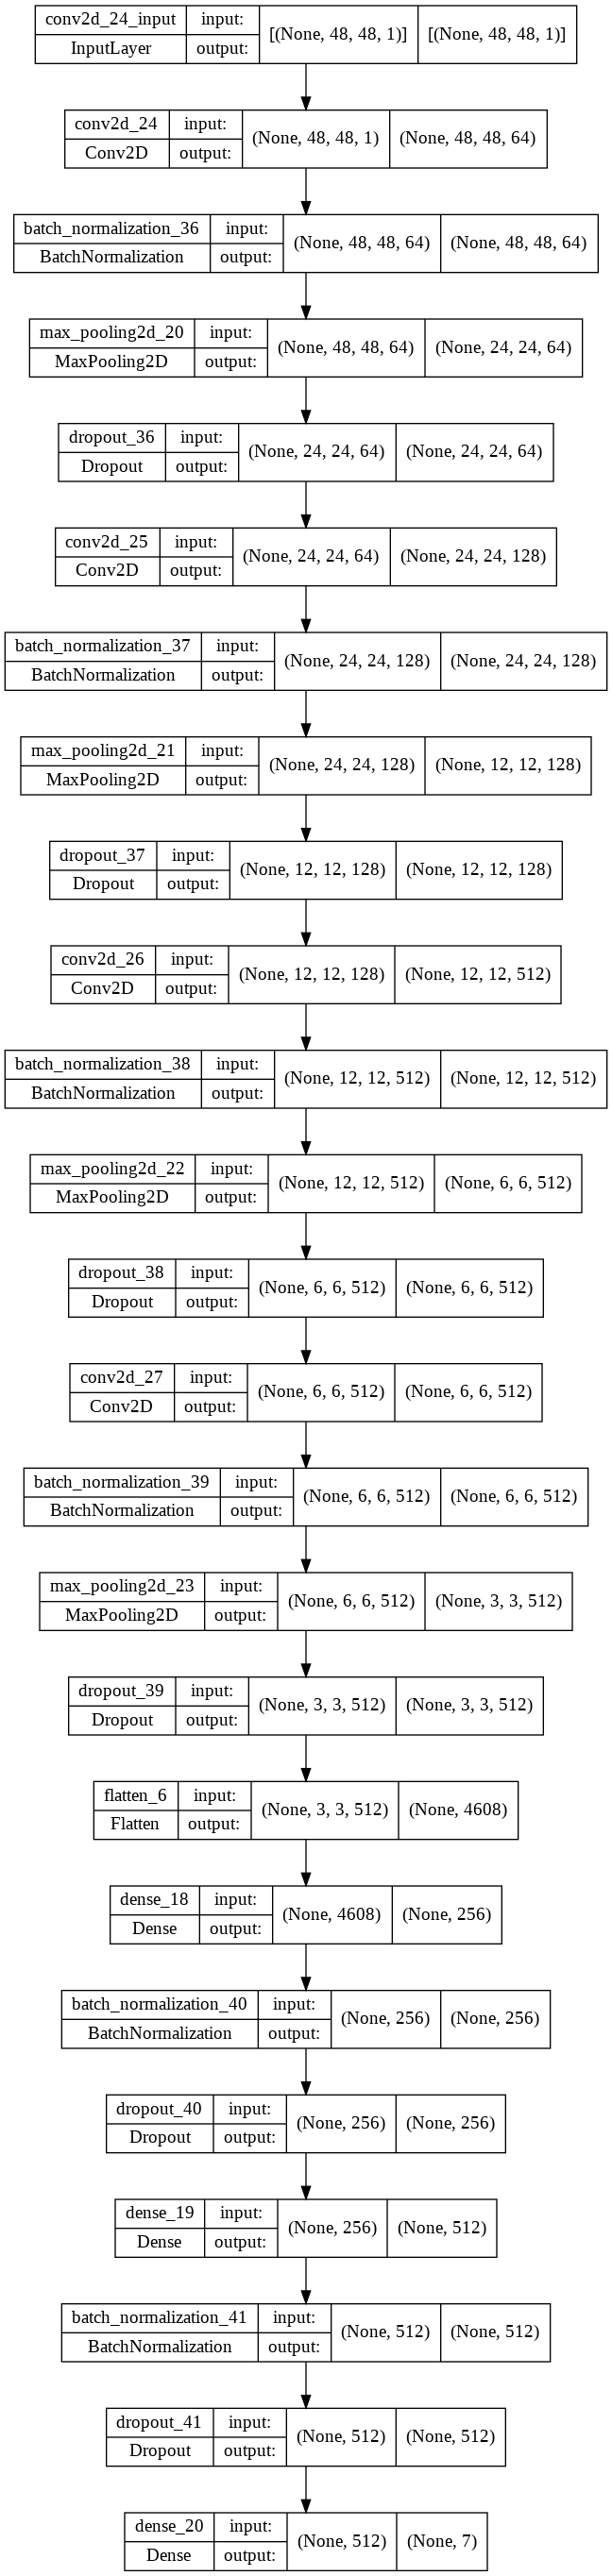

In [ ]:
model = combined_model_2()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
history6 = train_model(model, 30, 64)
model.evaluate(x_test, y_test)

Epoch 1/30
707/708 [============================>.] - ETA: 0s - loss: 2.0732 - accuracy: 0.2627
Epoch 1: val_loss improved from inf to 2.02089, saving model to best-model.h5
708/708 [==============================] - 32s 43ms/step - loss: 2.0727 - accuracy: 0.2628 - val_loss: 2.0209 - val_accuracy: 0.2960 - lr: 1.0000e-04
Epoch 2/30
707/708 [============================>.] - ETA: 0s - loss: 1.6464 - accuracy: 0.4002
Epoch 2: val_loss improved from 2.02089 to 1.44083, saving model to best-model.h5
708/708 [==============================] - 30s 42ms/step - loss: 1.6462 - accuracy: 0.4004 - val_loss: 1.4408 - val_accuracy: 0.4688 - lr: 1.0000e-04
Epoch 3/30
707/708 [============================>.] - ETA: 0s - loss: 1.3828 - accuracy: 0.4893
Epoch 3: val_loss improved from 1.44083 to 1.23598, saving model to best-model.h5
708/708 [==============================] - 30s 42ms/step - loss: 1.3827 - accuracy: 0.4894 - val_loss: 1.2360 - val_accuracy: 0.5348 - lr: 1.0000e-04
Epoch 4/30
707/708 [

[0.733145534992218, 0.839968204498291]

##### **Combined Model 2 Results** <a id="22"></a>


Min validation loss: 0.6231619715690613 
Max validation loss: 2.020892858505249 
Min validation acc: 0.2959872782230377 
Max validation acc: 0.839690089225769


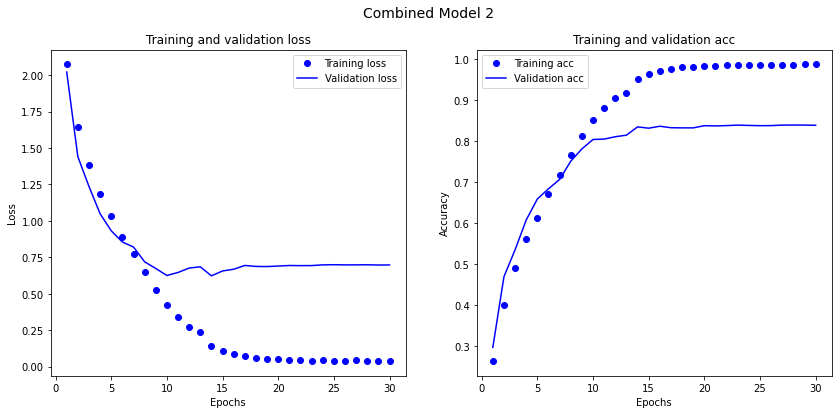

In [ ]:
plot_model_history(history6, name="Combined Model 2")

##### **Model 2 vs Combined Model 2** <a id="23"></a>


Model 2 validation loss: 0.5889896154403687 
Combined Model 2 validation loss: 0.6231619715690613

Model 2 validation accuracy: 0.8458482027053833 
Combined Model 2 validation accuracy: 0.839690089225769


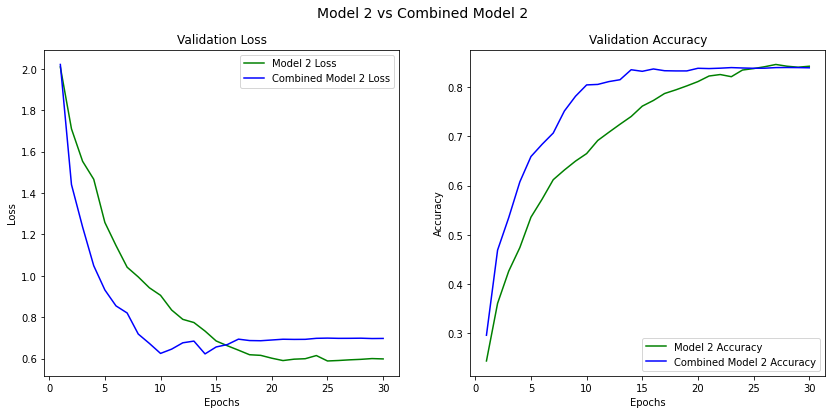

In [ ]:
compare_model_history(history2, history6, name="Model 2 vs Combined Model 2", key1="Model 2", key2="Combined Model 2")

#### **Adamax Optimiser with Learning Rate of 0.0005** <a id="24"></a>

In [ ]:
def combined_model_3():
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1:])))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 2nd convolutional layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 3rd convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))

  # 4th convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.25))
  model.add(layers.Flatten())

  # 1st fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))

  # 2nd fully connected dense layer
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.25))

  # final dense layer with number of classes
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizers.Adamax(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

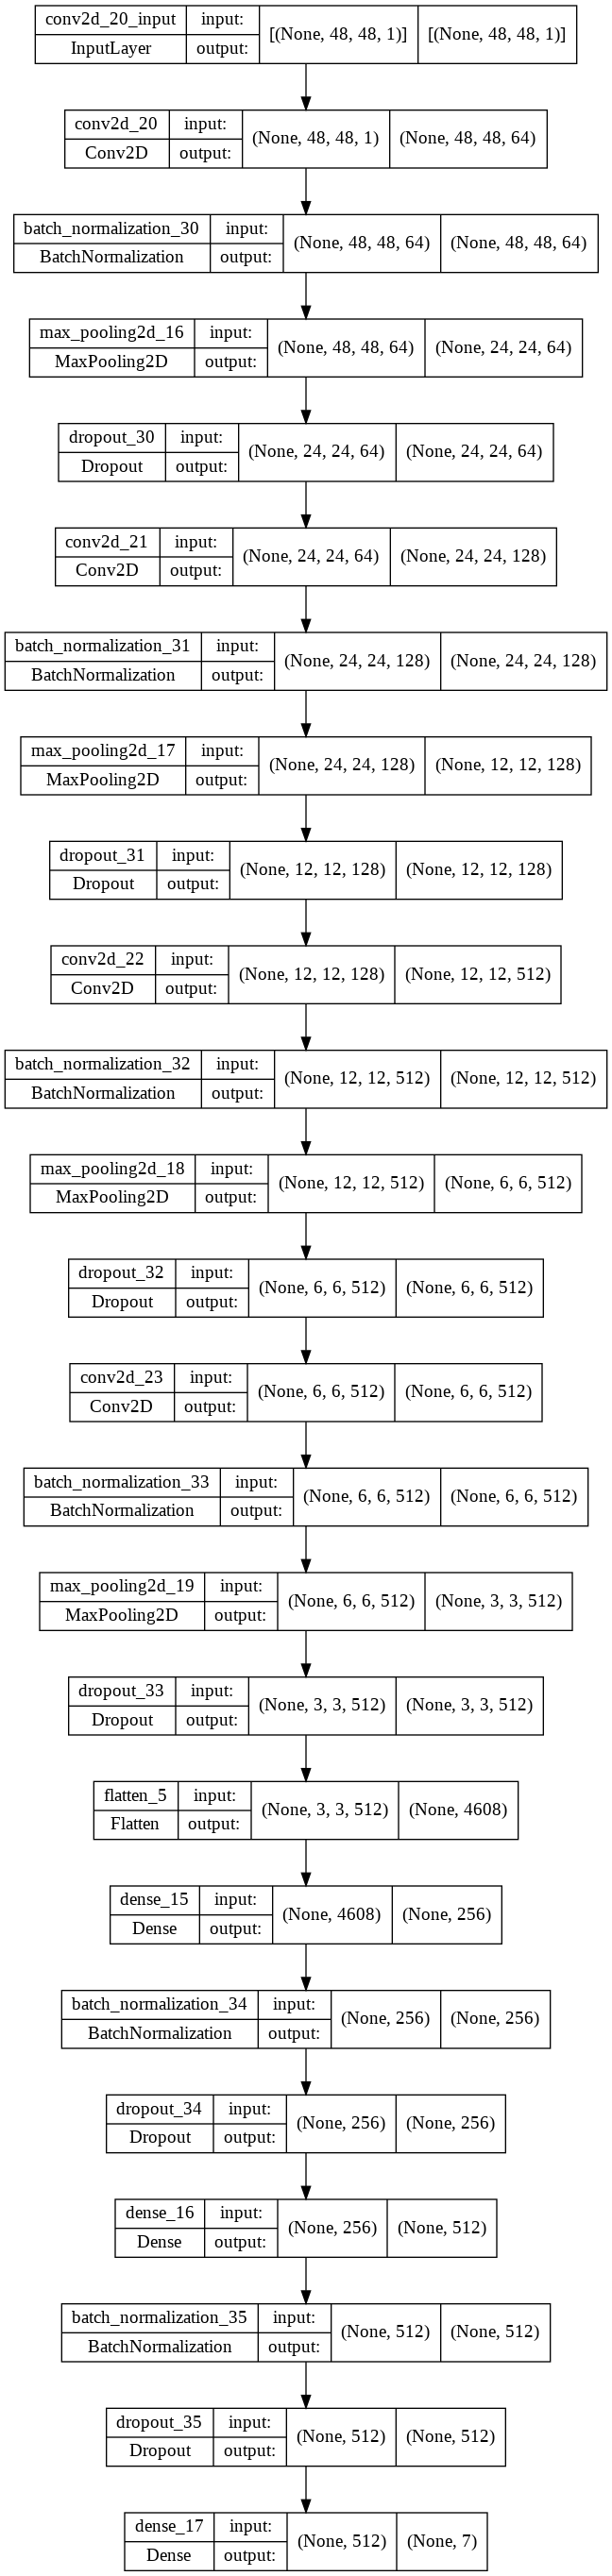

In [ ]:
model = combined_model_3()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
history7 = train_model(model, 30, 64)
model.evaluate(x_test, y_test)

Epoch 1/30
707/708 [============================>.] - ETA: 0s - loss: 2.1592 - accuracy: 0.2287
Epoch 1: val_loss improved from inf to 2.03815, saving model to best-model.h5
708/708 [==============================] - 20s 27ms/step - loss: 2.1588 - accuracy: 0.2288 - val_loss: 2.0381 - val_accuracy: 0.2515 - lr: 5.0000e-04
Epoch 2/30
706/708 [============================>.] - ETA: 0s - loss: 1.7901 - accuracy: 0.3404
Epoch 2: val_loss improved from 2.03815 to 1.59138, saving model to best-model.h5
708/708 [==============================] - 19s 26ms/step - loss: 1.7895 - accuracy: 0.3405 - val_loss: 1.5914 - val_accuracy: 0.4146 - lr: 5.0000e-04
Epoch 3/30
707/708 [============================>.] - ETA: 0s - loss: 1.5113 - accuracy: 0.4379
Epoch 3: val_loss improved from 1.59138 to 1.41898, saving model to best-model.h5
708/708 [==============================] - 19s 26ms/step - loss: 1.5110 - accuracy: 0.4380 - val_loss: 1.4190 - val_accuracy: 0.4787 - lr: 5.0000e-04
Epoch 4/30
707/708 [

[0.6536846160888672, 0.8444974422454834]

##### **Combined Model 3 Results** <a id="25"></a>


Min validation loss: 0.5822529792785645 
Max validation loss: 2.038146734237671 
Min validation acc: 0.25148987770080566 
Max validation acc: 0.8438617587089539


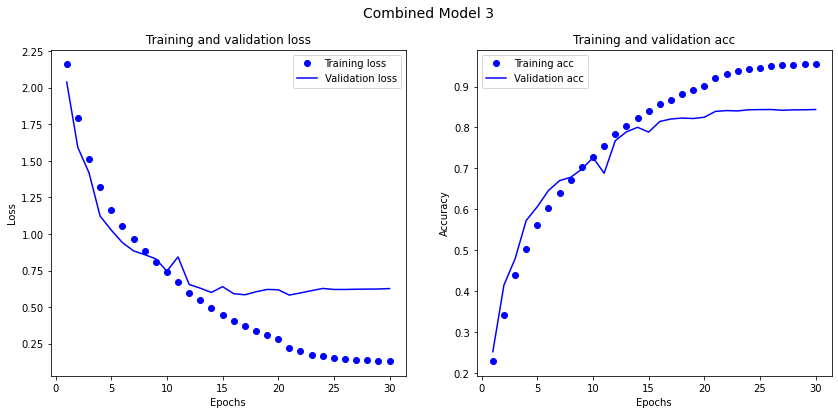

In [ ]:
plot_model_history(history7, name="Combined Model 3")

##### **Model 2 vs Combined Model 3** <a id="26"></a>


Model 2 validation loss: 0.5889896154403687 
Combined Model 3 validation loss: 0.5822529792785645

Model 2 validation accuracy: 0.8458482027053833 
Combined Model 3 validation accuracy: 0.8438617587089539


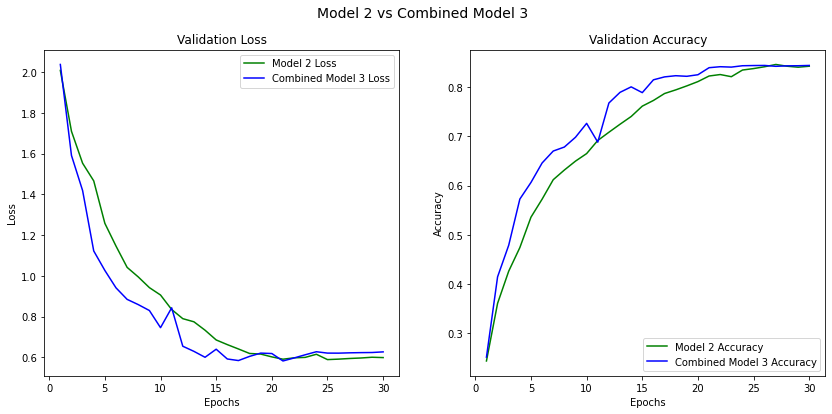

In [ ]:
compare_model_history(history2, history7, name="Model 2 vs Combined Model 3", key1="Model 2", key2="Combined Model 3")

#### **Final Combined Model** <a id="27"></a>

In [ ]:
def final_combined_model():
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1:])))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.3))

  # 2nd convolutional layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.3))

  # 3rd convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.3))

  # 4th convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())

  # 1st fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.3))

  # 2nd fully connected dense layer
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.3))

  # final dense layer with number of classes
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizers.Adamax(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

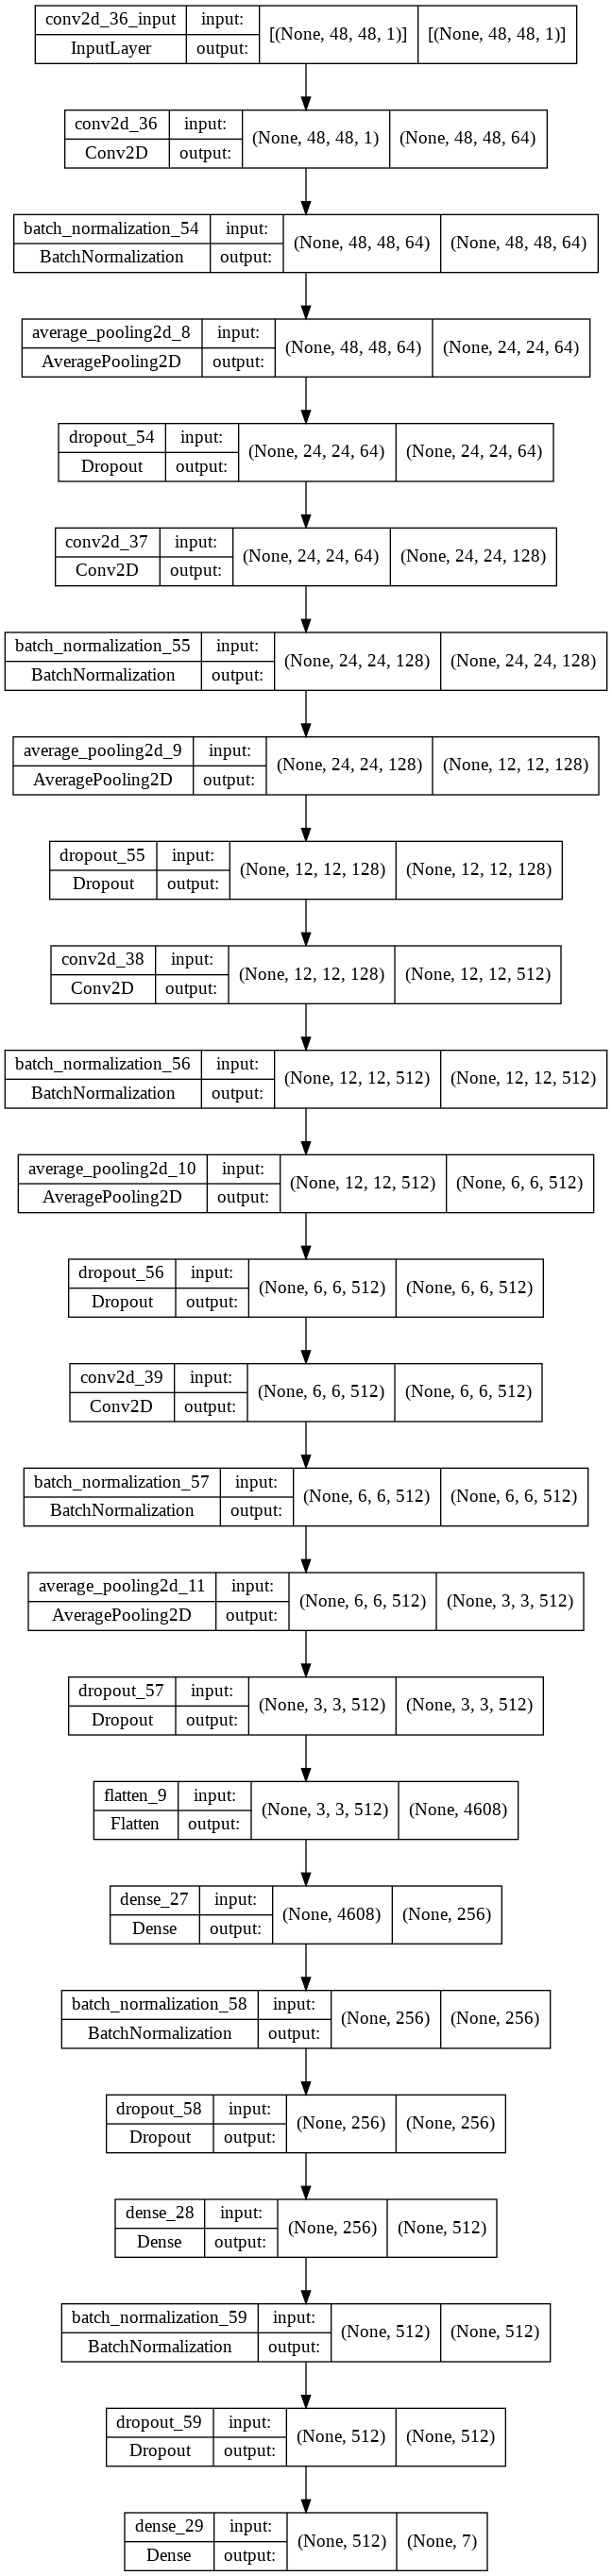

In [ ]:
model = final_combined_model()
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
history8 = train_model(model, 30, 64)
model.evaluate(x_test, y_test)

Epoch 1/30
707/708 [============================>.] - ETA: 0s - loss: 2.2181 - accuracy: 0.2147
Epoch 1: val_loss improved from inf to 1.75674, saving model to best-model.h5
708/708 [==============================] - 20s 26ms/step - loss: 2.2177 - accuracy: 0.2149 - val_loss: 1.7567 - val_accuracy: 0.3117 - lr: 5.0000e-04
Epoch 2/30
707/708 [============================>.] - ETA: 0s - loss: 1.8615 - accuracy: 0.3190
Epoch 2: val_loss improved from 1.75674 to 1.53602, saving model to best-model.h5
708/708 [==============================] - 18s 26ms/step - loss: 1.8609 - accuracy: 0.3193 - val_loss: 1.5360 - val_accuracy: 0.4213 - lr: 5.0000e-04
Epoch 3/30
708/708 [==============================] - ETA: 0s - loss: 1.5475 - accuracy: 0.4253
Epoch 3: val_loss improved from 1.53602 to 1.30146, saving model to best-model.h5
708/708 [==============================] - 18s 26ms/step - loss: 1.5475 - accuracy: 0.4253 - val_loss: 1.3015 - val_accuracy: 0.5095 - lr: 5.0000e-04
Epoch 4/30
707/708 [

[0.6120489835739136, 0.8456892967224121]

##### **Final Combination Results** <a id="28"></a>


Min validation loss: 0.5680626630783081 
Max validation loss: 1.7567416429519653 
Min validation acc: 0.3116805851459503 
Max validation acc: 0.845252275466919


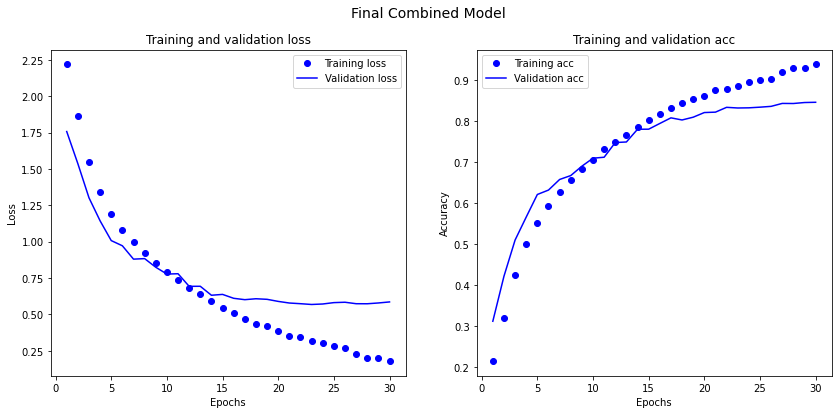

In [ ]:
plot_model_history(history8, name="Final Combined Model")

##### **Model 2 vs Final Combined Model** <a id="29"></a>


Model 2 validation loss: 0.5889896154403687 
Final Combined Model validation loss: 0.5680626630783081

Model 2 validation accuracy: 0.8458482027053833 
Final Combined Model validation accuracy: 0.845252275466919


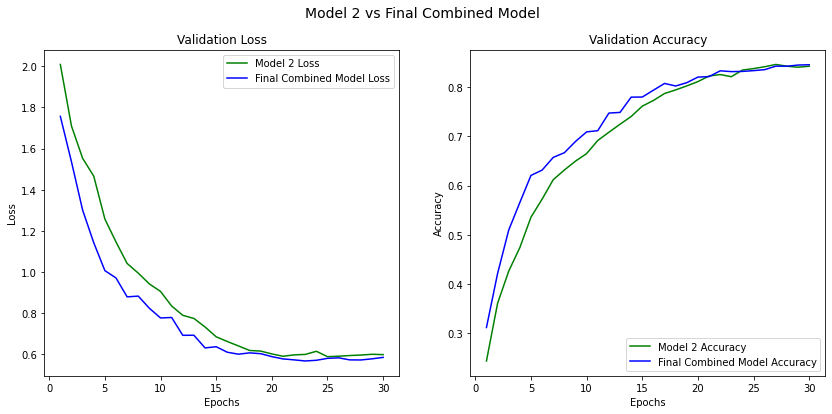

In [ ]:
compare_model_history(history2, history8, name="Model 2 vs Final Combined Model", key1="Model 2", key2="Final Combined Model")

#### **Final Combined Model with Data Augmentation** <a id="30"></a>

Data Augmentation Samples has been saved


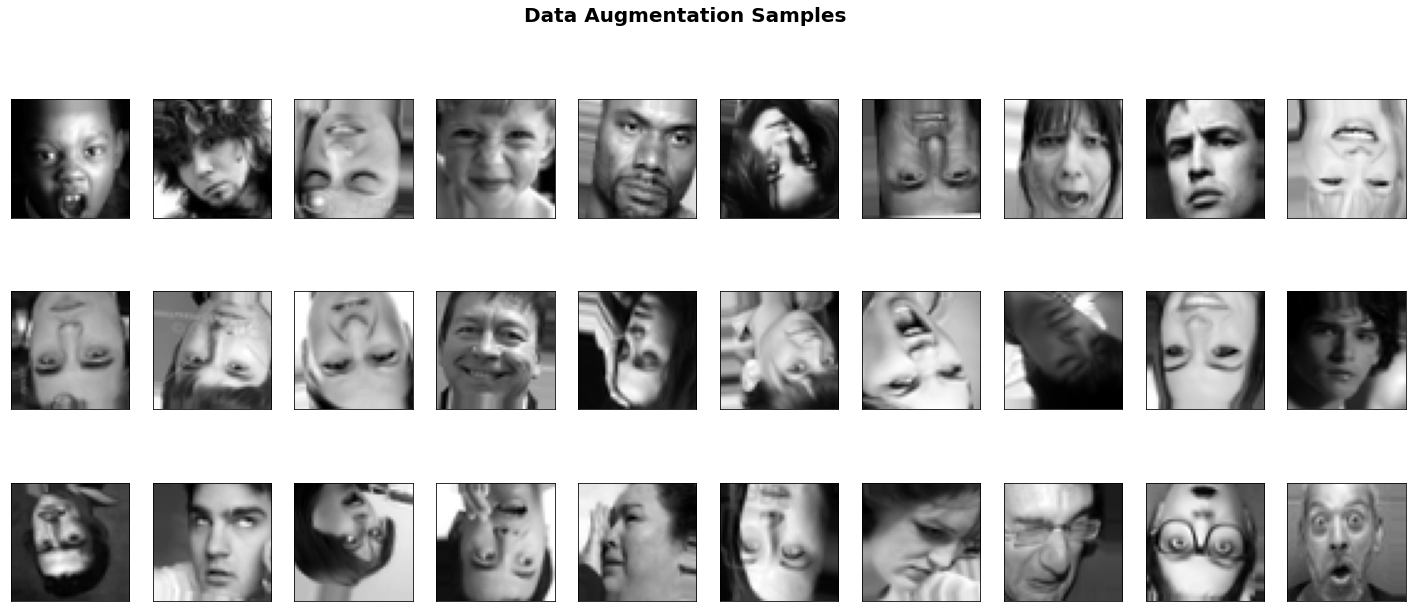

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=10, # rotating images randomly from 0 to 180 degrees
    zoom_range = 0.1, # zooming into the image
    width_shift_range=0.1, # horizontally shifting the images
    height_shift_range=0.1, # vertically shifting the images
    horizontal_flip=True, # allows horizontal flipping of images
    vertical_flip=True, # allows vertical flipping of images
    fill_mode='nearest') # replaces the empty area with the nearest pixel values

plot_augmentation_samples(train_datagen)

In [ ]:
model = final_combined_model()

history9 = train_augmented_model(model, train_datagen, 80, 128)
model.evaluate(x_test, y_test)

Epoch 1/80
352/353 [============================>.] - ETA: 0s - loss: 2.2990 - accuracy: 0.1946
Epoch 1: val_loss improved from inf to 2.01496, saving model to best-model.h5
353/353 [==============================] - 18s 48ms/step - loss: 2.2985 - accuracy: 0.1949 - val_loss: 2.0150 - val_accuracy: 0.1561 - lr: 5.0000e-04
Epoch 2/80
352/353 [============================>.] - ETA: 0s - loss: 2.0626 - accuracy: 0.2353
Epoch 2: val_loss improved from 2.01496 to 1.73165, saving model to best-model.h5
353/353 [==============================] - 17s 47ms/step - loss: 2.0623 - accuracy: 0.2353 - val_loss: 1.7317 - val_accuracy: 0.3172 - lr: 5.0000e-04
Epoch 3/80
352/353 [============================>.] - ETA: 0s - loss: 1.9164 - accuracy: 0.2801
Epoch 3: val_loss improved from 1.73165 to 1.64016, saving model to best-model.h5
353/353 [==============================] - 17s 47ms/step - loss: 1.9161 - accuracy: 0.2802 - val_loss: 1.6402 - val_accuracy: 0.3659 - lr: 5.0000e-04
Epoch 4/80
352/353 [

[0.5668871402740479, 0.8199443817138672]

##### **Data Augmentation Results** <a id="31"></a>


Min validation loss: 0.5454151034355164 
Max validation loss: 2.0149643421173096 
Min validation acc: 0.15613825619220734 
Max validation acc: 0.8212157487869263


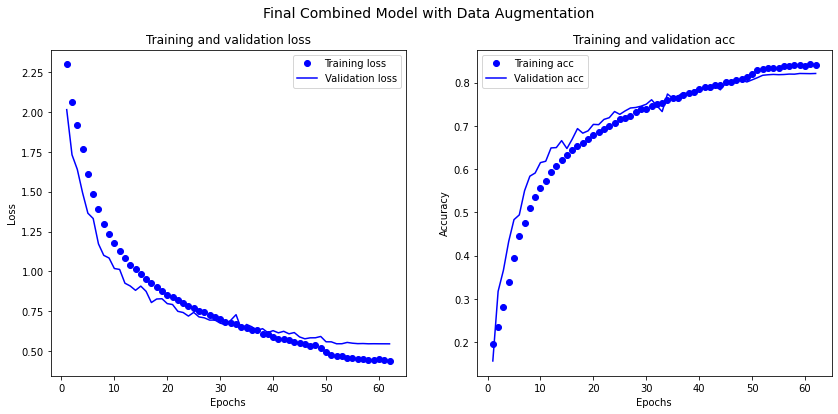

In [ ]:
plot_model_history(history9, name="Final Combined Model with Data Augmentation")

### **Final Model** <a id="32"></a>

In [ ]:
def final_model():
  model = models.Sequential()

  # 1st convolutional layer
  model.add(layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1:])))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.3))

  # 2nd convolutional layer
  model.add(layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.3))

  # 3rd convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.3))

  # 4th convolutional layer
  model.add(layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.AveragePooling2D((2, 2)))
  model.add(layers.Dropout(0.35))
  model.add(layers.Flatten())

  # 1st fully connected dense layer
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.3))

  # 2nd fully connected dense layer
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.3))

  # final dense layer with number of classes
  model.add(layers.Dense(7, activation='softmax'))

  # compile the model
  model.compile(optimizer=optimizers.Adamax(learning_rate=0.0005, beta_1=0.9, beta_2=0.999), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

Final Model Architecture has been saved


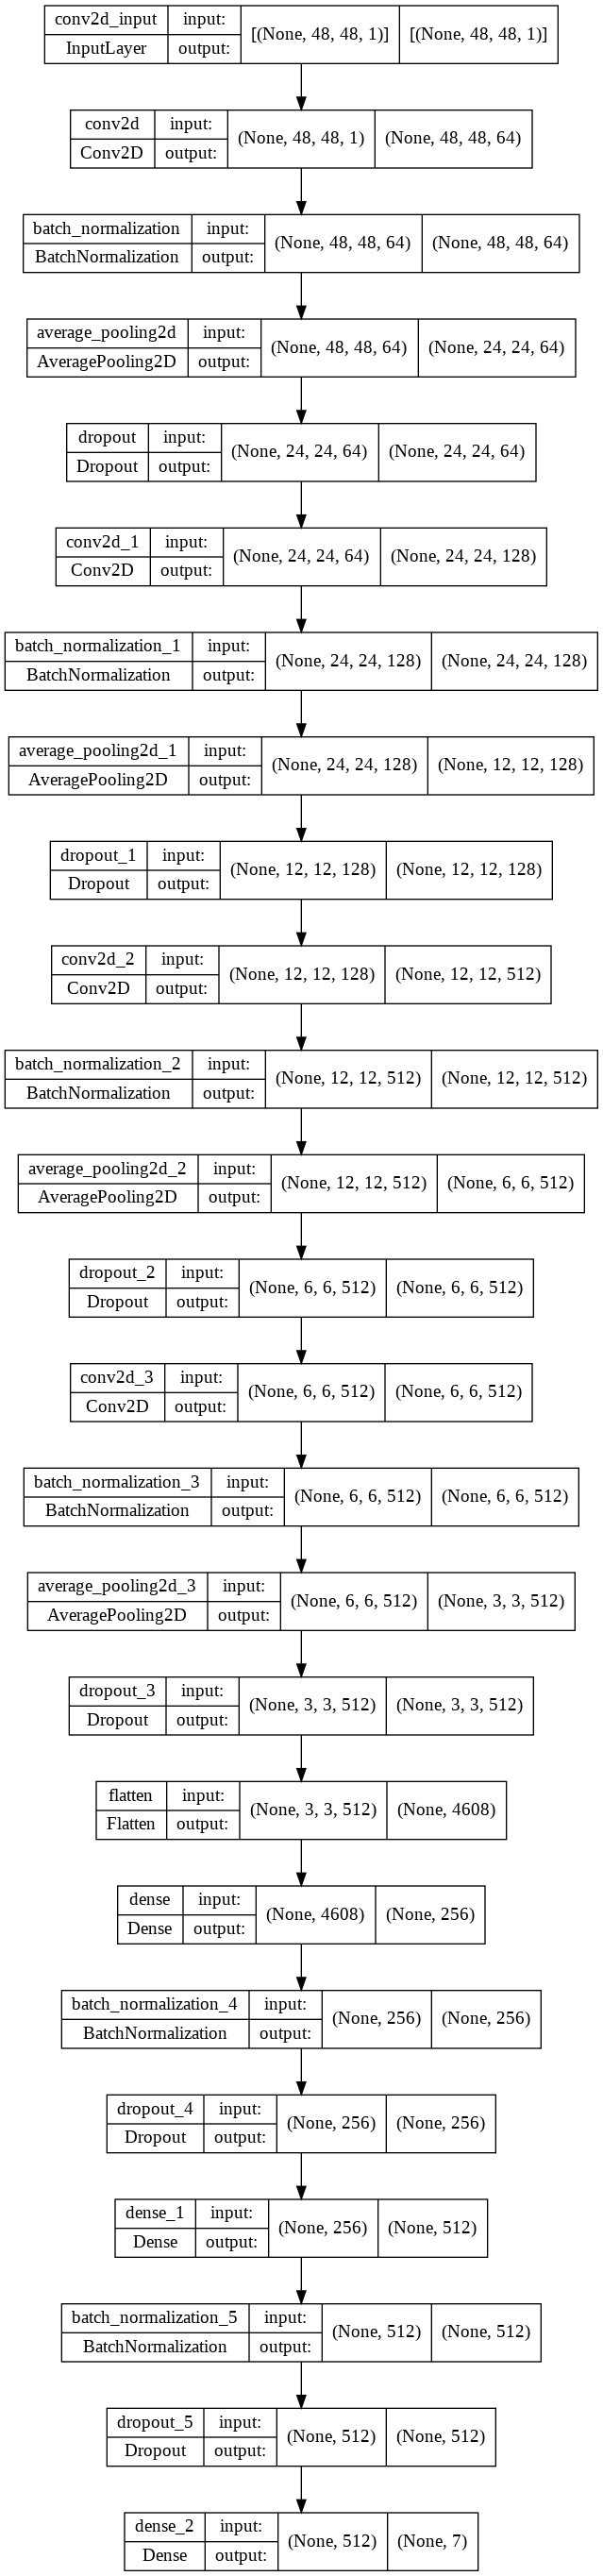

<Figure size 432x288 with 0 Axes>

In [ ]:
model = final_model()
save_figure("Final Model Architecture")
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
history10 = train_model(model, 30, 64)
model.evaluate(x_test, y_test)

Epoch 1/30
706/708 [============================>.] - ETA: 0s - loss: 2.1827 - accuracy: 0.2345
Epoch 1: val_loss improved from inf to 1.72933, saving model to best-model.h5
708/708 [==============================] - 20s 26ms/step - loss: 2.1823 - accuracy: 0.2346 - val_loss: 1.7293 - val_accuracy: 0.3385 - lr: 5.0000e-04
Epoch 2/30
707/708 [============================>.] - ETA: 0s - loss: 1.7687 - accuracy: 0.3559
Epoch 2: val_loss improved from 1.72933 to 1.42490, saving model to best-model.h5
708/708 [==============================] - 18s 26ms/step - loss: 1.7684 - accuracy: 0.3560 - val_loss: 1.4249 - val_accuracy: 0.4495 - lr: 5.0000e-04
Epoch 3/30
707/708 [============================>.] - ETA: 0s - loss: 1.4954 - accuracy: 0.4462
Epoch 3: val_loss improved from 1.42490 to 1.31612, saving model to best-model.h5
708/708 [==============================] - 19s 26ms/step - loss: 1.4952 - accuracy: 0.4463 - val_loss: 1.3161 - val_accuracy: 0.5052 - lr: 5.0000e-04
Epoch 4/30
707/708 [

[0.6066526174545288, 0.8407627940177917]

In [ ]:
model.save('final-model.h5', overwrite=True)

#### **Final Model with Data Augmentation** <a id="33"></a>

Data Augmentation Samples has been saved


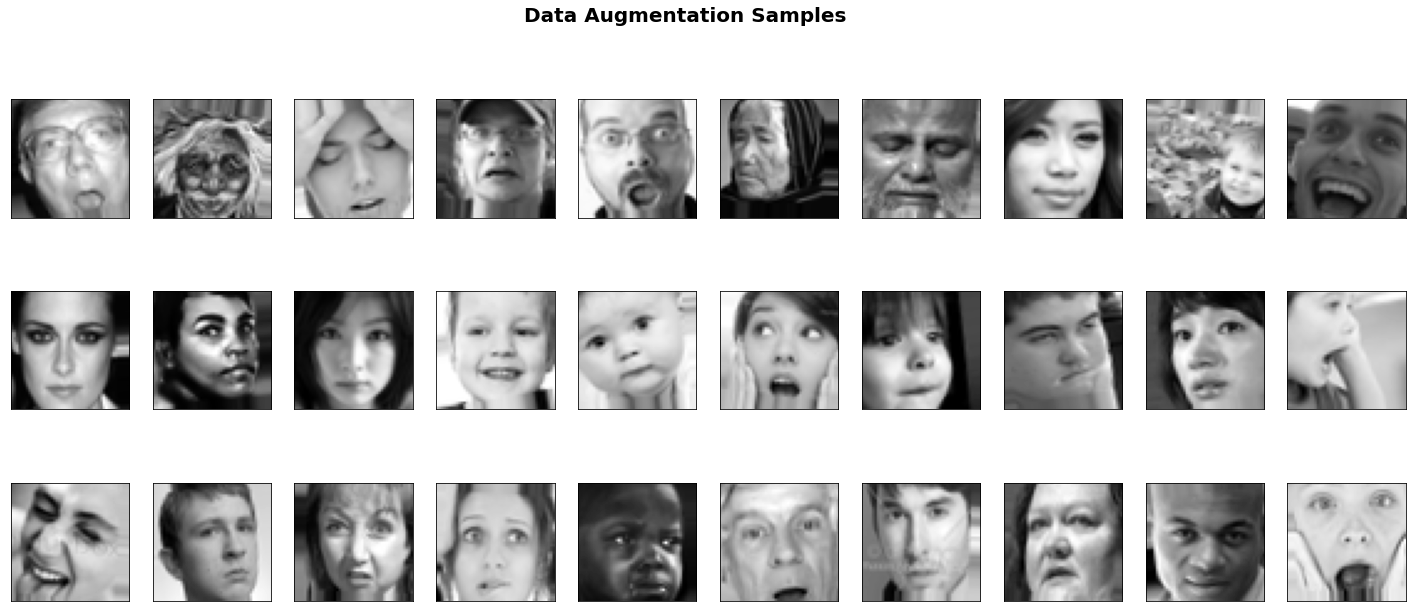

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=10, # rotating images randomly from 0 to 180 degrees
    zoom_range = 0.1, # zooming into the image
    width_shift_range=0.1, # horizontally shifting the images
    height_shift_range=0.1, # vertically shifting the images
    horizontal_flip=False, # doesn't allow horizontal flipping of images
    vertical_flip=False, # doesn't allow vertical flipping of images
    fill_mode='nearest') # replaces the empty area with the nearest pixel values

plot_augmentation_samples(train_datagen) 

In [ ]:
model = final_model()

history11 = train_augmented_model(model, train_datagen, 80, 128)
model.evaluate(x_test, y_test)

Epoch 1/80
352/353 [============================>.] - ETA: 0s - loss: 2.3058 - accuracy: 0.1922
Epoch 1: val_loss improved from inf to 1.95658, saving model to best-model.h5
353/353 [==============================] - 30s 53ms/step - loss: 2.3053 - accuracy: 0.1923 - val_loss: 1.9566 - val_accuracy: 0.1522 - lr: 5.0000e-04
Epoch 2/80
352/353 [============================>.] - ETA: 0s - loss: 2.0774 - accuracy: 0.2315
Epoch 2: val_loss improved from 1.95658 to 1.76976, saving model to best-model.h5
353/353 [==============================] - 17s 47ms/step - loss: 2.0771 - accuracy: 0.2316 - val_loss: 1.7698 - val_accuracy: 0.3101 - lr: 5.0000e-04
Epoch 3/80
352/353 [============================>.] - ETA: 0s - loss: 1.9431 - accuracy: 0.2733
Epoch 3: val_loss improved from 1.76976 to 1.61022, saving model to best-model.h5
353/353 [==============================] - 17s 47ms/step - loss: 1.9431 - accuracy: 0.2732 - val_loss: 1.6102 - val_accuracy: 0.3834 - lr: 5.0000e-04
Epoch 4/80
353/353 [

[0.6213833093643188, 0.7894318699836731]

In [ ]:
model.save('augmented-model.h5', overwrite=True)

#### **Final Model Results** <a id="34"></a>


Min validation loss: 0.590213418006897 
Max validation loss: 1.729331135749817 
Min validation acc: 0.33849820494651794 
Max validation acc: 0.835915744304657


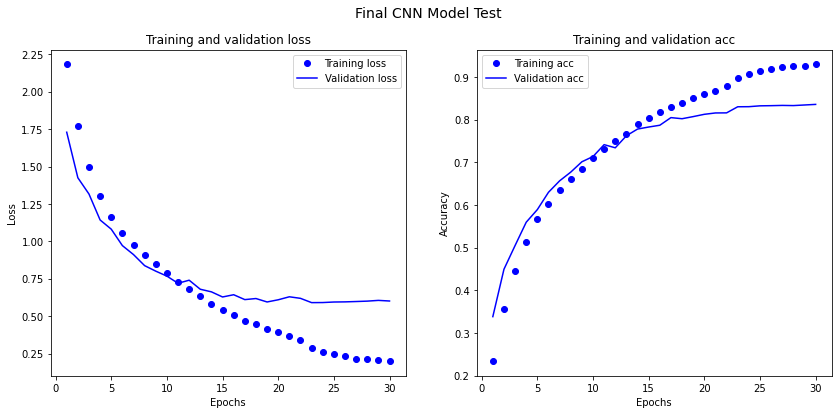

In [ ]:
plot_model_history(history10, name="Final CNN Model Test")


Min validation loss: 0.5459099411964417 
Max validation loss: 1.7715320587158203 
Min validation acc: 0.3178386986255646 
Max validation acc: 0.851807713508606


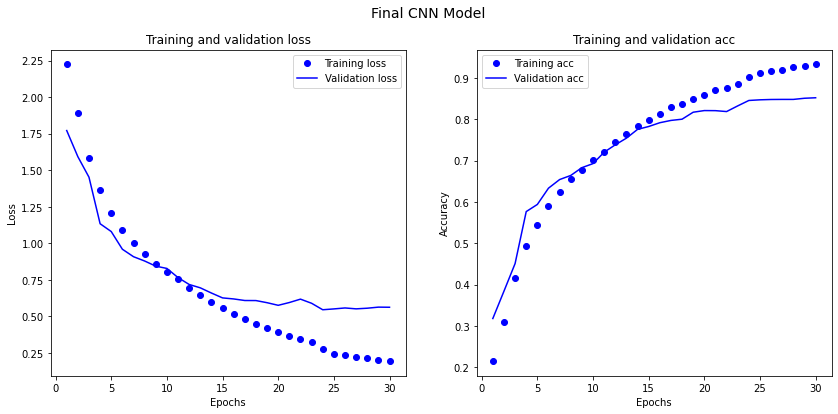

In [ ]:
plot_model_history(history10, name="Final CNN Model")


Min validation loss: 0.6261454224586487 
Max validation loss: 1.9565800428390503 
Min validation acc: 0.1521652787923813 
Max validation acc: 0.7820818424224854


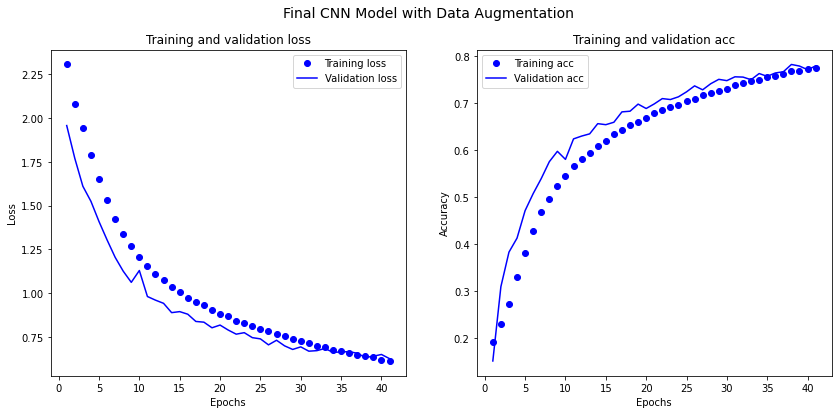

In [ ]:
plot_model_history(history11, name="Final CNN Model with Data Augmentation")

### **Predictions for Model without Data Augmentation** <a id="35"></a>

In [ ]:
# model = tf.keras.models.load_model('final-model.h5')
model = tf.keras.models.load_model('/content/drive/MyDrive/FER H5/final-model.h5') # saved the best model on google drive

data = []
predicted = np.argmax(model.predict(x_test), axis=1)
actual = np.argmax(y_test, axis=1)
validate = []
table = PrettyTable(['Predicted Emotion', 'Actual Emotion', 'Predicted Emotion Text', 'Actual Emotion Text', 'Validate'])

for i in range(50):
  validate.append('True' if predicted[i] == actual[i] else 'False')
  data.append([predicted[i], 
               actual[i], 
               decoded_emotions[predicted[i]], 
               decoded_emotions[actual[i]], 
               validate[i]]
              )
for record in data:
  table.add_row(record)
print(table)

true_predictions = validate.count('True')
print(f"\nNumber of true predictions: {true_predictions}/{len(validate)}")

+-------------------+----------------+------------------------+---------------------+----------+
| Predicted Emotion | Actual Emotion | Predicted Emotion Text | Actual Emotion Text | Validate |
+-------------------+----------------+------------------------+---------------------+----------+
|         6         |       6        |        Neutral         |       Neutral       |   True   |
|         5         |       5        |        Suprised        |       Suprised      |   True   |
|         5         |       5        |        Suprised        |       Suprised      |   True   |
|         6         |       6        |        Neutral         |       Neutral       |   True   |
|         1         |       1        |       Disgusted        |      Disgusted      |   True   |
|         0         |       0        |         Angry          |        Angry        |   True   |
|         3         |       3        |         Happy          |        Happy        |   True   |
|         4         |       4 

Predictions vs Truth has been saved


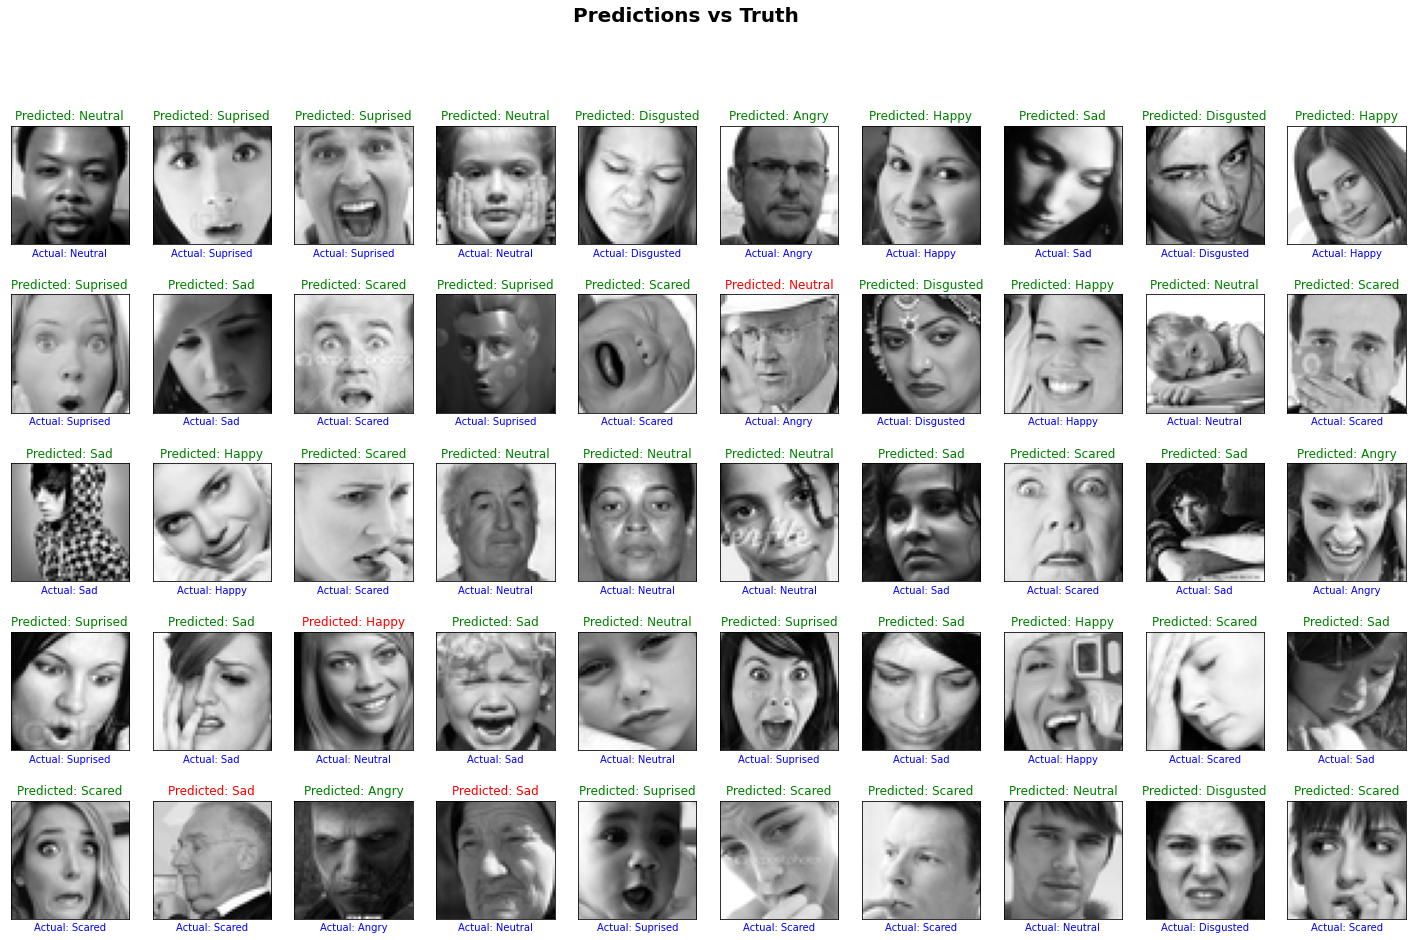

In [ ]:
fig = plt.figure(figsize=(25, 15))
fig.suptitle("Predictions vs Truth", fontsize=20, weight='bold')
rows = 5
columns = 10

for i in range(rows * columns):
  fig.add_subplot(rows, columns, i+1)
  plt.grid(False)
  plt.imshow(np.squeeze(x_test[i]), cmap=plt.cm.gray)
  plt.xticks([])
  plt.yticks([])
  if decoded_emotions[predicted[i]] != decoded_emotions[actual[i]]:
    plt.title("Predicted: " + decoded_emotions[predicted[i]], color='r')
  else:
    plt.title("Predicted: " + decoded_emotions[predicted[i]], color='g')
  plt.xlabel("Actual: " + decoded_emotions[actual[i]], color='b')
save_figure("Predictions vs Truth", tight_layout=False)
plt.show()

In [ ]:
print(classification_report(actual, predicted, target_names=decoded_emotions.values()))

              precision    recall  f1-score   support

       Angry       0.80      0.84      0.82      1770
   Disgusted       0.98      1.00      0.99      1778
      Scared       0.83      0.77      0.80      1775
       Happy       0.86      0.83      0.84      1872
         Sad       0.73      0.70      0.72      1825
    Suprised       0.91      0.95      0.93      1755
     Neutral       0.75      0.79      0.77      1810

    accuracy                           0.84     12585
   macro avg       0.84      0.84      0.84     12585
weighted avg       0.84      0.84      0.84     12585



Confusion Matrix has been saved


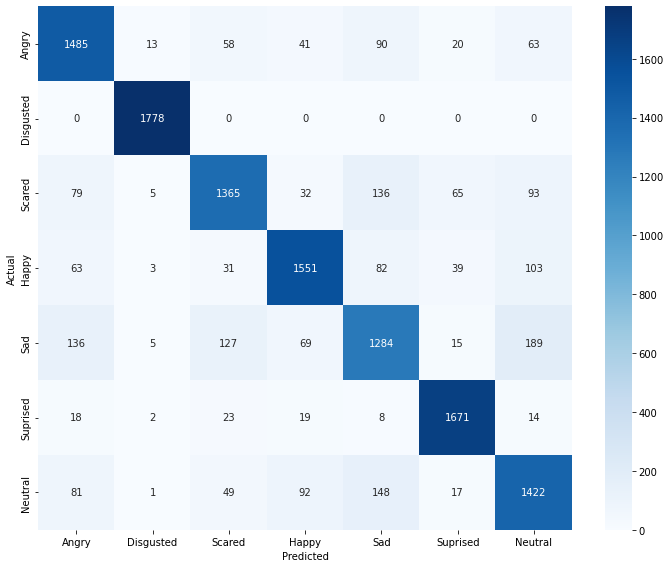

In [ ]:
confusion_matrix = tf.math.confusion_matrix(actual, predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, 
            cmap='Blues', fmt='d', 
            xticklabels=decoded_emotions.values(),
            yticklabels=decoded_emotions.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
save_figure("Confusion Matrix")

### **Predictions for Model with Data Augmentation** <a id="36"></a>

In [ ]:
model = tf.keras.models.load_model('augmented-model.h5')

data = []
predicted = np.argmax(model.predict(x_test), axis=1)
actual = np.argmax(y_test, axis=1)
validate = []
table = PrettyTable(['Predicted Emotion', 'Actual Emotion', 'Predicted Emotion Text', 'Actual Emotion Text', 'Validate'])

for i in range(50):
  validate.append('True' if predicted[i] == actual[i] else 'False')
  data.append([predicted[i], 
               actual[i], 
               decoded_emotions[predicted[i]], 
               decoded_emotions[actual[i]], 
               validate[i]]
              )
for record in data:
  table.add_row(record)
print(table)

true_predictions = validate.count('True')
print(f"\nNumber of true predictions: {true_predictions}/{len(validate)}")

+-------------------+----------------+------------------------+---------------------+----------+
| Predicted Emotion | Actual Emotion | Predicted Emotion Text | Actual Emotion Text | Validate |
+-------------------+----------------+------------------------+---------------------+----------+
|         3         |       6        |         Happy          |       Neutral       |  False   |
|         5         |       5        |        Suprised        |       Suprised      |   True   |
|         0         |       5        |         Angry          |       Suprised      |  False   |
|         6         |       6        |        Neutral         |       Neutral       |   True   |
|         1         |       1        |       Disgusted        |      Disgusted      |   True   |
|         0         |       0        |         Angry          |        Angry        |   True   |
|         3         |       3        |         Happy          |        Happy        |   True   |
|         4         |       4 

Predictions vs Truth has been saved


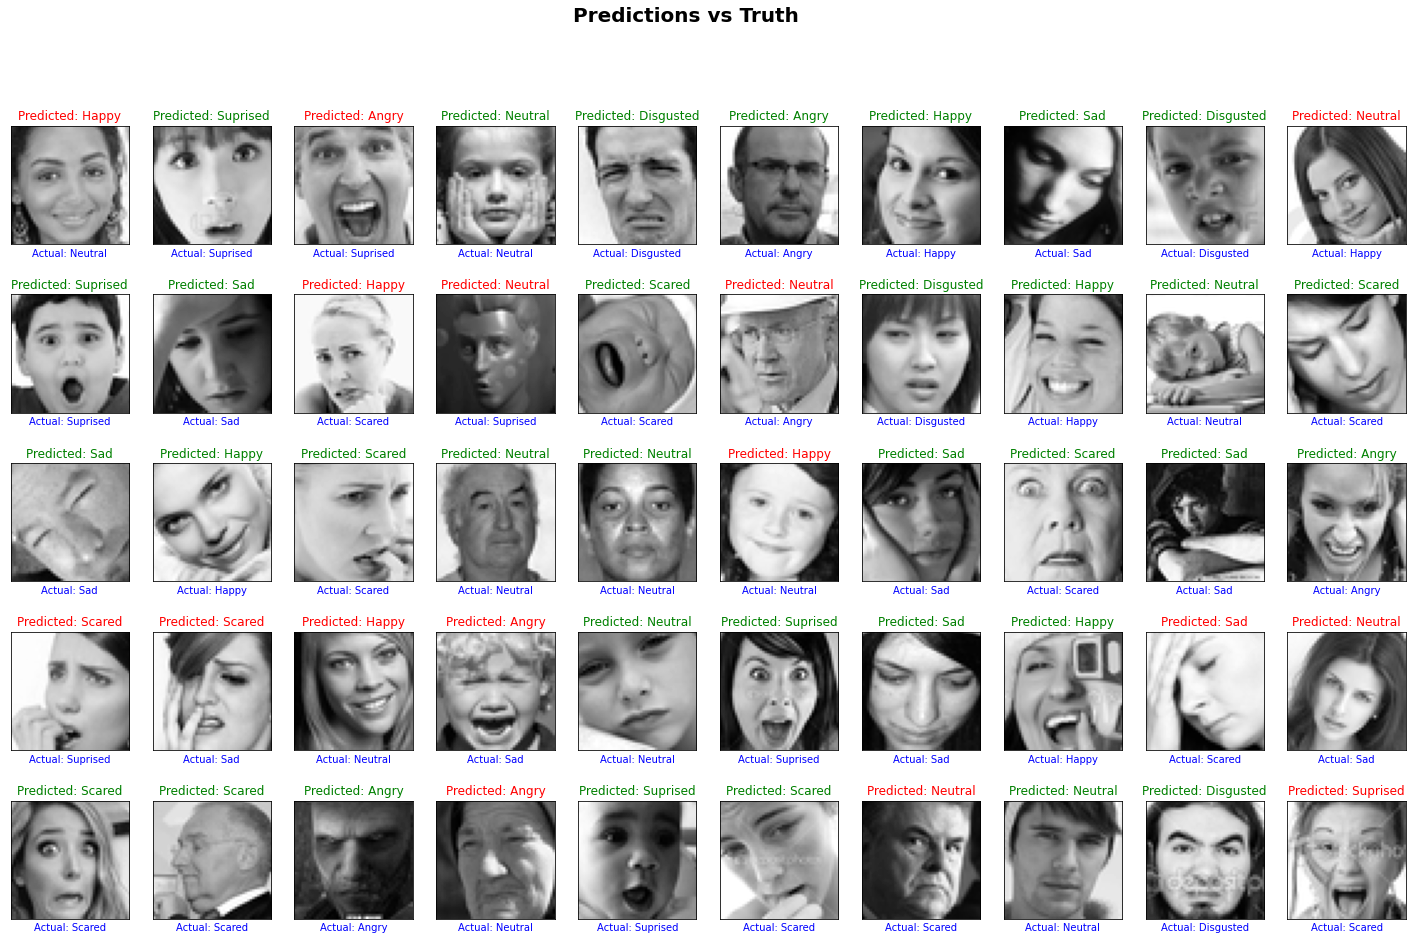

In [ ]:
fig = plt.figure(figsize=(25, 15))
fig.suptitle("Predictions vs Truth", fontsize=20, weight='bold')
rows = 5
columns = 10

for i in range(rows * columns):
  fig.add_subplot(rows, columns, i+1)
  plt.grid(False)
  plt.imshow(np.squeeze(x_test[i]), cmap=plt.cm.gray)
  plt.xticks([])
  plt.yticks([])
  if decoded_emotions[predicted[i]] != decoded_emotions[actual[i]]:
    plt.title("Predicted: " + decoded_emotions[predicted[i]], color='r')
  else:
    plt.title("Predicted: " + decoded_emotions[predicted[i]], color='g')
  plt.xlabel("Actual: " + decoded_emotions[actual[i]], color='b')
save_figure("Predictions vs Truth", tight_layout=False)
plt.show()

In [ ]:
print(classification_report(actual, predicted, target_names=decoded_emotions.values()))

              precision    recall  f1-score   support

       Angry       0.74      0.78      0.76      1770
   Disgusted       0.99      1.00      0.99      1778
      Scared       0.75      0.64      0.69      1775
       Happy       0.87      0.83      0.85      1872
         Sad       0.70      0.59      0.64      1825
    Suprised       0.85      0.92      0.88      1755
     Neutral       0.64      0.77      0.70      1810

    accuracy                           0.79     12585
   macro avg       0.79      0.79      0.79     12585
weighted avg       0.79      0.79      0.79     12585



Confusion Matrix has been saved


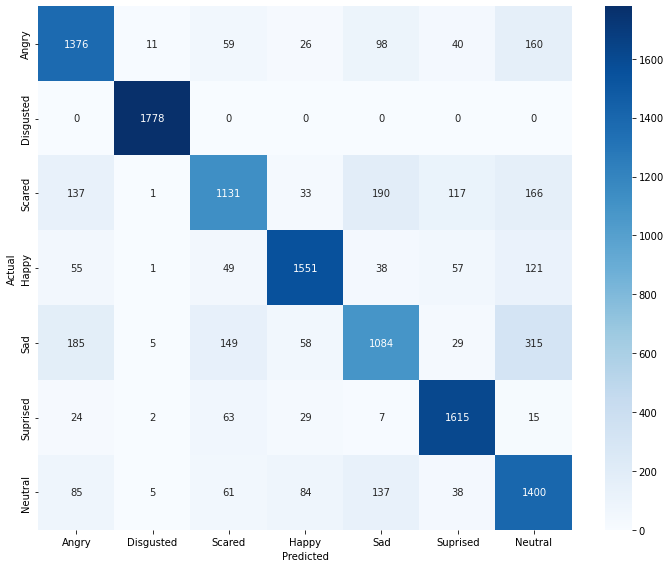

In [ ]:
confusion_matrix = tf.math.confusion_matrix(actual, predicted)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, 
            cmap='Blues', fmt='d', 
            xticklabels=decoded_emotions.values(),
            yticklabels=decoded_emotions.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
save_figure("Confusion Matrix")

### **Saving the Model** <a id="37"></a>

In [ ]:
fer_to_json = model.to_json()  
with open("best-model.json", "w") as json_file:  
    json_file.write(fer_to_json)  

### **Conclusions** <a id="38"></a>

|Model| Validation Loss| Validation Accuracy| True predictions on first 50 test images| Best Model?|
|:-----------:|:-------:|:-------:|:------:|:------:|
| Final Model | 0.5459 | 0.8518 | 46/50 | Yes |
| Final Model with Data Augmentation | 0.6261 | 0.7821 | 34/50 | No |